In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
from exceptions.Exceptions import ModelNotFoundException
from models import *
from models.custom_data_parallel import CustomDataParallel
from loguru import logger
from torch.autograd import Variable
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from sklearn import svm

In [2]:
models = {
    "RegNetX_200MF": RegNetX_200MF(),
    "VGG": VGG('VGG19'),
    "ResNet18": ResNet18(),
    "GoogLeNet": GoogLeNet(),
    "DenseNet121": DenseNet121(),
    "ResNeXt29_2x64d": ResNeXt29_2x64d(),
    "MobileNet": MobileNet(),
    #"MobileNetV2": MobileNetV2(),
    "PreActResNet18": PreActResNet18(),
    #"DPN92": DPN92(),
    "SENet18": SENet18(),
    "EfficientNetB0": EfficientNetB0()
}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
learning_rate = 0.01
ckpt_path = None
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Some hyperparams
model_name = 'MobileNet'
net = RegNetX_200MF()
num_epochs = 10
start_epoch = 0
learning_rate = 0.01
train_batch_size = 128
test_batch_size = 100
trainset,trainloader,testset,testloader=None,None,None,None
criterion=None
optimizer=None
scheduler=None

# Set up parameters and optimizer

In [3]:
def set_up_params(net):
    global criterion, scheduler, ckpt_path, optimizer
    ckpt_path = "./checkpoint/"
    # Set up optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate,
                        momentum=0.9, weight_decay=5e-4)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                        step_size=10.0, gamma=0.1)

    ckpt_path = ckpt_path + model_name + ".torch"

## Prepare data (CIFAR)

In [4]:
def set_up_dataset():
    global trainset, trainloader, testset, testloader
    logger.info('==> Preparing data..')
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=train_batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=test_batch_size, shuffle=True, num_workers=2)
    

## Train and test functions, and start training


In [5]:
def train(epoch, net):
        net.train()
        train_loss = 0
        correct = 0
        total = 0
        log_interval = 10
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + loss.item()
            _, predicted = outputs.max(1)
            total = total + targets.size(0)
            
            max_logit = outputs.data.max(1, keepdim=True)[1]
            correct = max_logit.eq( targets.data.view_as(max_logit) ).sum()
            processed = ((batch_idx + 1) * train_batch_size)
            
            accuracy = (100. * correct) / train_batch_size
            progress = (100. * processed) / len(trainset)

            if (batch_idx + 1) % log_interval == 0: 
                    logger.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLocal Loss: {:.6f}\t Accuracy: {:.6f}\t', 
                    epoch, processed, len(trainset), progress, loss.item(), accuracy)


def test(epoch, net):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0.0
    total = 0
    acc = 0

    with torch.no_grad():
        for _, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            acc = 100.*correct/total

        logger.info('Test set: loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(loss.item(), correct, len(testset), acc))  

        if acc > best_acc:
            print('Saving..')
            state = {
                'net': net.state_dict(),
                'acc': acc,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            
            logger.info( 'Saving/Serving model: epoch: {}, loss: {}, path: {}', epoch, loss.item(), ckpt_path )
            torch.save( {'epoch': epoch,
                        'model_state_dict': net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()}, ckpt_path)
            best_acc = acc

def train_model(start_epoch, net):
    for epoch in range(start_epoch, start_epoch+num_epochs):
        train(epoch, net)
        scheduler.step()
        test(epoch, net)

# Train all models

In [6]:
def train_all_models():
    global model_name, best_acc
    
    for model in models.keys():
        model_name = model
        net = models[model]
        net = net.to(device)
        
        set_up_params(net)
        set_up_dataset()
        train_model(0, net)
        best_acc = 0

In [7]:
train_all_models()

2021-01-26 20:40:18.251 | INFO     | __main__:set_up_dataset:3 - ==> Preparing data..


Files already downloaded and verified
Files already downloaded and verified


2021-01-26 20:40:21.369 | INFO     | __main__:train:28 - Train Epoch: 0 [1280/50000 (3%)]	Local Loss: 2.473292	 Accuracy: 10.937500	
2021-01-26 20:40:22.824 | INFO     | __main__:train:28 - Train Epoch: 0 [2560/50000 (5%)]	Local Loss: 2.349913	 Accuracy: 17.187500	
2021-01-26 20:40:24.284 | INFO     | __main__:train:28 - Train Epoch: 0 [3840/50000 (8%)]	Local Loss: 2.218921	 Accuracy: 19.531250	
2021-01-26 20:40:25.737 | INFO     | __main__:train:28 - Train Epoch: 0 [5120/50000 (10%)]	Local Loss: 2.415867	 Accuracy: 14.843750	
2021-01-26 20:40:27.195 | INFO     | __main__:train:28 - Train Epoch: 0 [6400/50000 (13%)]	Local Loss: 2.208343	 Accuracy: 17.187500	
2021-01-26 20:40:28.668 | INFO     | __main__:train:28 - Train Epoch: 0 [7680/50000 (15%)]	Local Loss: 2.101216	 Accuracy: 19.531250	
2021-01-26 20:40:30.122 | INFO     | __main__:train:28 - Train Epoch: 0 [8960/50000 (18%)]	Local Loss: 1.855499	 Accuracy: 19.531250	
2021-01-26 20:40:31.586 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:41:24.277 | INFO     | __main__:train:28 - Train Epoch: 1 [1280/50000 (3%)]	Local Loss: 1.288106	 Accuracy: 48.437500	
2021-01-26 20:41:25.884 | INFO     | __main__:train:28 - Train Epoch: 1 [2560/50000 (5%)]	Local Loss: 1.476392	 Accuracy: 39.062500	
2021-01-26 20:41:27.423 | INFO     | __main__:train:28 - Train Epoch: 1 [3840/50000 (8%)]	Local Loss: 1.486187	 Accuracy: 48.437500	
2021-01-26 20:41:28.951 | INFO     | __main__:train:28 - Train Epoch: 1 [5120/50000 (10%)]	Local Loss: 1.269419	 Accuracy: 57.031250	
2021-01-26 20:41:30.466 | INFO     | __main__:train:28 - Train Epoch: 1 [6400/50000 (13%)]	Local Loss: 1.383739	 Accuracy: 50.000000	
2021-01-26 20:41:31.963 | INFO     | __main__:train:28 - Train Epoch: 1 [7680/50000 (15%)]	Local Loss: 1.332374	 Accuracy: 48.437500	
2021-01-26 20:41:33.489 | INFO     | __main__:train:28 - Train Epoch: 1 [8960/50000 (18%)]	Local Loss: 1.329421	 Accuracy: 50.781250	
2021-01-26 20:41:35.006 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:42:28.720 | INFO     | __main__:train:28 - Train Epoch: 2 [1280/50000 (3%)]	Local Loss: 1.123850	 Accuracy: 58.593750	
2021-01-26 20:42:30.258 | INFO     | __main__:train:28 - Train Epoch: 2 [2560/50000 (5%)]	Local Loss: 1.083499	 Accuracy: 57.031250	
2021-01-26 20:42:31.774 | INFO     | __main__:train:28 - Train Epoch: 2 [3840/50000 (8%)]	Local Loss: 1.066271	 Accuracy: 60.156250	
2021-01-26 20:42:33.270 | INFO     | __main__:train:28 - Train Epoch: 2 [5120/50000 (10%)]	Local Loss: 1.030646	 Accuracy: 63.281250	
2021-01-26 20:42:34.783 | INFO     | __main__:train:28 - Train Epoch: 2 [6400/50000 (13%)]	Local Loss: 1.155754	 Accuracy: 57.812500	
2021-01-26 20:42:36.275 | INFO     | __main__:train:28 - Train Epoch: 2 [7680/50000 (15%)]	Local Loss: 1.020736	 Accuracy: 57.031250	
2021-01-26 20:42:37.797 | INFO     | __main__:train:28 - Train Epoch: 2 [8960/50000 (18%)]	Local Loss: 1.062331	 Accuracy: 62.500000	
2021-01-26 20:42:39.360 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:43:32.519 | INFO     | __main__:train:28 - Train Epoch: 3 [1280/50000 (3%)]	Local Loss: 0.812382	 Accuracy: 70.312500	
2021-01-26 20:43:34.087 | INFO     | __main__:train:28 - Train Epoch: 3 [2560/50000 (5%)]	Local Loss: 0.881675	 Accuracy: 64.062500	
2021-01-26 20:43:35.635 | INFO     | __main__:train:28 - Train Epoch: 3 [3840/50000 (8%)]	Local Loss: 0.890356	 Accuracy: 71.875000	
2021-01-26 20:43:37.198 | INFO     | __main__:train:28 - Train Epoch: 3 [5120/50000 (10%)]	Local Loss: 0.748523	 Accuracy: 75.000000	
2021-01-26 20:43:38.760 | INFO     | __main__:train:28 - Train Epoch: 3 [6400/50000 (13%)]	Local Loss: 0.891337	 Accuracy: 71.093750	
2021-01-26 20:43:40.322 | INFO     | __main__:train:28 - Train Epoch: 3 [7680/50000 (15%)]	Local Loss: 0.761015	 Accuracy: 78.125000	
2021-01-26 20:43:41.869 | INFO     | __main__:train:28 - Train Epoch: 3 [8960/50000 (18%)]	Local Loss: 0.824372	 Accuracy: 71.875000	
2021-01-26 20:43:43.370 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:44:36.467 | INFO     | __main__:train:28 - Train Epoch: 4 [1280/50000 (3%)]	Local Loss: 0.721358	 Accuracy: 74.218750	
2021-01-26 20:44:38.030 | INFO     | __main__:train:28 - Train Epoch: 4 [2560/50000 (5%)]	Local Loss: 0.773355	 Accuracy: 74.218750	
2021-01-26 20:44:39.594 | INFO     | __main__:train:28 - Train Epoch: 4 [3840/50000 (8%)]	Local Loss: 0.860533	 Accuracy: 67.968750	
2021-01-26 20:44:41.205 | INFO     | __main__:train:28 - Train Epoch: 4 [5120/50000 (10%)]	Local Loss: 0.744016	 Accuracy: 74.218750	
2021-01-26 20:44:42.770 | INFO     | __main__:train:28 - Train Epoch: 4 [6400/50000 (13%)]	Local Loss: 0.705103	 Accuracy: 75.000000	
2021-01-26 20:44:44.338 | INFO     | __main__:train:28 - Train Epoch: 4 [7680/50000 (15%)]	Local Loss: 0.516426	 Accuracy: 82.812500	
2021-01-26 20:44:45.863 | INFO     | __main__:train:28 - Train Epoch: 4 [8960/50000 (18%)]	Local Loss: 0.693741	 Accuracy: 71.875000	
2021-01-26 20:44:47.369 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:46:45.002 | INFO     | __main__:train:28 - Train Epoch: 6 [1280/50000 (3%)]	Local Loss: 0.679943	 Accuracy: 75.000000	
2021-01-26 20:46:46.544 | INFO     | __main__:train:28 - Train Epoch: 6 [2560/50000 (5%)]	Local Loss: 0.628591	 Accuracy: 77.343750	
2021-01-26 20:46:48.046 | INFO     | __main__:train:28 - Train Epoch: 6 [3840/50000 (8%)]	Local Loss: 0.573256	 Accuracy: 78.125000	
2021-01-26 20:46:49.547 | INFO     | __main__:train:28 - Train Epoch: 6 [5120/50000 (10%)]	Local Loss: 0.416062	 Accuracy: 83.593750	
2021-01-26 20:46:51.069 | INFO     | __main__:train:28 - Train Epoch: 6 [6400/50000 (13%)]	Local Loss: 0.655694	 Accuracy: 78.125000	
2021-01-26 20:46:52.612 | INFO     | __main__:train:28 - Train Epoch: 6 [7680/50000 (15%)]	Local Loss: 0.612431	 Accuracy: 80.468750	
2021-01-26 20:46:54.163 | INFO     | __main__:train:28 - Train Epoch: 6 [8960/50000 (18%)]	Local Loss: 0.631716	 Accuracy: 76.562500	
2021-01-26 20:46:55.768 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:47:49.567 | INFO     | __main__:train:28 - Train Epoch: 7 [1280/50000 (3%)]	Local Loss: 0.447292	 Accuracy: 89.062500	
2021-01-26 20:47:51.043 | INFO     | __main__:train:28 - Train Epoch: 7 [2560/50000 (5%)]	Local Loss: 0.560128	 Accuracy: 81.250000	
2021-01-26 20:47:52.523 | INFO     | __main__:train:28 - Train Epoch: 7 [3840/50000 (8%)]	Local Loss: 0.448453	 Accuracy: 87.500000	
2021-01-26 20:47:54.010 | INFO     | __main__:train:28 - Train Epoch: 7 [5120/50000 (10%)]	Local Loss: 0.630267	 Accuracy: 79.687500	
2021-01-26 20:47:55.504 | INFO     | __main__:train:28 - Train Epoch: 7 [6400/50000 (13%)]	Local Loss: 0.787452	 Accuracy: 71.875000	
2021-01-26 20:47:57.026 | INFO     | __main__:train:28 - Train Epoch: 7 [7680/50000 (15%)]	Local Loss: 0.534731	 Accuracy: 81.250000	
2021-01-26 20:47:58.565 | INFO     | __main__:train:28 - Train Epoch: 7 [8960/50000 (18%)]	Local Loss: 0.572897	 Accuracy: 82.031250	
2021-01-26 20:48:00.134 | INFO     | __main__:train:28 - Train Ep

Saving..
Files already downloaded and verified
Files already downloaded and verified


2021-01-26 20:51:03.140 | INFO     | __main__:train:28 - Train Epoch: 0 [1280/50000 (3%)]	Local Loss: 2.174098	 Accuracy: 17.968750	
2021-01-26 20:51:03.801 | INFO     | __main__:train:28 - Train Epoch: 0 [2560/50000 (5%)]	Local Loss: 1.961869	 Accuracy: 26.562500	
2021-01-26 20:51:04.480 | INFO     | __main__:train:28 - Train Epoch: 0 [3840/50000 (8%)]	Local Loss: 1.859532	 Accuracy: 32.812500	
2021-01-26 20:51:05.188 | INFO     | __main__:train:28 - Train Epoch: 0 [5120/50000 (10%)]	Local Loss: 1.768904	 Accuracy: 37.500000	
2021-01-26 20:51:05.911 | INFO     | __main__:train:28 - Train Epoch: 0 [6400/50000 (13%)]	Local Loss: 1.874405	 Accuracy: 28.906250	
2021-01-26 20:51:06.624 | INFO     | __main__:train:28 - Train Epoch: 0 [7680/50000 (15%)]	Local Loss: 1.614640	 Accuracy: 35.937500	
2021-01-26 20:51:07.346 | INFO     | __main__:train:28 - Train Epoch: 0 [8960/50000 (18%)]	Local Loss: 1.676676	 Accuracy: 39.843750	
2021-01-26 20:51:08.057 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:51:32.517 | INFO     | __main__:train:28 - Train Epoch: 1 [1280/50000 (3%)]	Local Loss: 1.258438	 Accuracy: 55.468750	
2021-01-26 20:51:33.215 | INFO     | __main__:train:28 - Train Epoch: 1 [2560/50000 (5%)]	Local Loss: 0.943048	 Accuracy: 65.625000	
2021-01-26 20:51:33.899 | INFO     | __main__:train:28 - Train Epoch: 1 [3840/50000 (8%)]	Local Loss: 1.426869	 Accuracy: 47.656250	
2021-01-26 20:51:34.618 | INFO     | __main__:train:28 - Train Epoch: 1 [5120/50000 (10%)]	Local Loss: 1.143813	 Accuracy: 60.937500	
2021-01-26 20:51:35.328 | INFO     | __main__:train:28 - Train Epoch: 1 [6400/50000 (13%)]	Local Loss: 1.215044	 Accuracy: 54.687500	
2021-01-26 20:51:36.040 | INFO     | __main__:train:28 - Train Epoch: 1 [7680/50000 (15%)]	Local Loss: 1.164064	 Accuracy: 61.718750	
2021-01-26 20:51:36.745 | INFO     | __main__:train:28 - Train Epoch: 1 [8960/50000 (18%)]	Local Loss: 1.125278	 Accuracy: 58.593750	
2021-01-26 20:51:37.419 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:52:01.976 | INFO     | __main__:train:28 - Train Epoch: 2 [1280/50000 (3%)]	Local Loss: 0.794106	 Accuracy: 70.312500	
2021-01-26 20:52:02.695 | INFO     | __main__:train:28 - Train Epoch: 2 [2560/50000 (5%)]	Local Loss: 0.832357	 Accuracy: 71.875000	
2021-01-26 20:52:03.367 | INFO     | __main__:train:28 - Train Epoch: 2 [3840/50000 (8%)]	Local Loss: 0.892893	 Accuracy: 66.406250	
2021-01-26 20:52:04.028 | INFO     | __main__:train:28 - Train Epoch: 2 [5120/50000 (10%)]	Local Loss: 0.926962	 Accuracy: 70.312500	
2021-01-26 20:52:04.714 | INFO     | __main__:train:28 - Train Epoch: 2 [6400/50000 (13%)]	Local Loss: 0.653904	 Accuracy: 79.687500	
2021-01-26 20:52:05.439 | INFO     | __main__:train:28 - Train Epoch: 2 [7680/50000 (15%)]	Local Loss: 0.757097	 Accuracy: 68.750000	
2021-01-26 20:52:06.156 | INFO     | __main__:train:28 - Train Epoch: 2 [8960/50000 (18%)]	Local Loss: 0.920998	 Accuracy: 70.312500	
2021-01-26 20:52:06.852 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:52:31.054 | INFO     | __main__:train:28 - Train Epoch: 3 [1280/50000 (3%)]	Local Loss: 0.734202	 Accuracy: 75.000000	
2021-01-26 20:52:31.774 | INFO     | __main__:train:28 - Train Epoch: 3 [2560/50000 (5%)]	Local Loss: 0.797308	 Accuracy: 71.093750	
2021-01-26 20:52:32.456 | INFO     | __main__:train:28 - Train Epoch: 3 [3840/50000 (8%)]	Local Loss: 0.556170	 Accuracy: 77.343750	
2021-01-26 20:52:33.118 | INFO     | __main__:train:28 - Train Epoch: 3 [5120/50000 (10%)]	Local Loss: 0.593259	 Accuracy: 78.125000	
2021-01-26 20:52:33.784 | INFO     | __main__:train:28 - Train Epoch: 3 [6400/50000 (13%)]	Local Loss: 0.736986	 Accuracy: 73.437500	
2021-01-26 20:52:34.497 | INFO     | __main__:train:28 - Train Epoch: 3 [7680/50000 (15%)]	Local Loss: 0.729528	 Accuracy: 75.781250	
2021-01-26 20:52:35.177 | INFO     | __main__:train:28 - Train Epoch: 3 [8960/50000 (18%)]	Local Loss: 0.596195	 Accuracy: 76.562500	
2021-01-26 20:52:35.846 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:53:00.173 | INFO     | __main__:train:28 - Train Epoch: 4 [1280/50000 (3%)]	Local Loss: 0.467716	 Accuracy: 82.031250	
2021-01-26 20:53:00.841 | INFO     | __main__:train:28 - Train Epoch: 4 [2560/50000 (5%)]	Local Loss: 0.555796	 Accuracy: 80.468750	
2021-01-26 20:53:01.508 | INFO     | __main__:train:28 - Train Epoch: 4 [3840/50000 (8%)]	Local Loss: 0.459657	 Accuracy: 82.031250	
2021-01-26 20:53:02.181 | INFO     | __main__:train:28 - Train Epoch: 4 [5120/50000 (10%)]	Local Loss: 0.589129	 Accuracy: 78.125000	
2021-01-26 20:53:02.860 | INFO     | __main__:train:28 - Train Epoch: 4 [6400/50000 (13%)]	Local Loss: 0.536199	 Accuracy: 81.250000	
2021-01-26 20:53:03.575 | INFO     | __main__:train:28 - Train Epoch: 4 [7680/50000 (15%)]	Local Loss: 0.435909	 Accuracy: 84.375000	
2021-01-26 20:53:04.283 | INFO     | __main__:train:28 - Train Epoch: 4 [8960/50000 (18%)]	Local Loss: 0.613885	 Accuracy: 79.687500	
2021-01-26 20:53:05.006 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:53:28.975 | INFO     | __main__:train:28 - Train Epoch: 5 [1280/50000 (3%)]	Local Loss: 0.408339	 Accuracy: 85.156250	
2021-01-26 20:53:29.637 | INFO     | __main__:train:28 - Train Epoch: 5 [2560/50000 (5%)]	Local Loss: 0.496478	 Accuracy: 82.812500	
2021-01-26 20:53:30.301 | INFO     | __main__:train:28 - Train Epoch: 5 [3840/50000 (8%)]	Local Loss: 0.386968	 Accuracy: 88.281250	
2021-01-26 20:53:31.011 | INFO     | __main__:train:28 - Train Epoch: 5 [5120/50000 (10%)]	Local Loss: 0.461970	 Accuracy: 81.250000	
2021-01-26 20:53:31.725 | INFO     | __main__:train:28 - Train Epoch: 5 [6400/50000 (13%)]	Local Loss: 0.387331	 Accuracy: 86.718750	
2021-01-26 20:53:32.410 | INFO     | __main__:train:28 - Train Epoch: 5 [7680/50000 (15%)]	Local Loss: 0.510041	 Accuracy: 82.031250	
2021-01-26 20:53:33.097 | INFO     | __main__:train:28 - Train Epoch: 5 [8960/50000 (18%)]	Local Loss: 0.513248	 Accuracy: 80.468750	
2021-01-26 20:53:33.816 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:54:26.812 | INFO     | __main__:train:28 - Train Epoch: 7 [1280/50000 (3%)]	Local Loss: 0.411197	 Accuracy: 89.843750	
2021-01-26 20:54:27.505 | INFO     | __main__:train:28 - Train Epoch: 7 [2560/50000 (5%)]	Local Loss: 0.236860	 Accuracy: 92.187500	
2021-01-26 20:54:28.206 | INFO     | __main__:train:28 - Train Epoch: 7 [3840/50000 (8%)]	Local Loss: 0.358455	 Accuracy: 87.500000	
2021-01-26 20:54:28.925 | INFO     | __main__:train:28 - Train Epoch: 7 [5120/50000 (10%)]	Local Loss: 0.456493	 Accuracy: 83.593750	
2021-01-26 20:54:29.602 | INFO     | __main__:train:28 - Train Epoch: 7 [6400/50000 (13%)]	Local Loss: 0.424945	 Accuracy: 85.937500	
2021-01-26 20:54:30.263 | INFO     | __main__:train:28 - Train Epoch: 7 [7680/50000 (15%)]	Local Loss: 0.292650	 Accuracy: 92.968750	
2021-01-26 20:54:30.926 | INFO     | __main__:train:28 - Train Epoch: 7 [8960/50000 (18%)]	Local Loss: 0.325669	 Accuracy: 88.281250	
2021-01-26 20:54:31.636 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:55:24.338 | INFO     | __main__:train:28 - Train Epoch: 9 [1280/50000 (3%)]	Local Loss: 0.362881	 Accuracy: 85.937500	
2021-01-26 20:55:25.031 | INFO     | __main__:train:28 - Train Epoch: 9 [2560/50000 (5%)]	Local Loss: 0.252370	 Accuracy: 91.406250	
2021-01-26 20:55:25.694 | INFO     | __main__:train:28 - Train Epoch: 9 [3840/50000 (8%)]	Local Loss: 0.281172	 Accuracy: 91.406250	
2021-01-26 20:55:26.361 | INFO     | __main__:train:28 - Train Epoch: 9 [5120/50000 (10%)]	Local Loss: 0.305630	 Accuracy: 91.406250	
2021-01-26 20:55:27.067 | INFO     | __main__:train:28 - Train Epoch: 9 [6400/50000 (13%)]	Local Loss: 0.314653	 Accuracy: 90.625000	
2021-01-26 20:55:27.742 | INFO     | __main__:train:28 - Train Epoch: 9 [7680/50000 (15%)]	Local Loss: 0.418012	 Accuracy: 85.937500	
2021-01-26 20:55:28.405 | INFO     | __main__:train:28 - Train Epoch: 9 [8960/50000 (18%)]	Local Loss: 0.321965	 Accuracy: 91.406250	
2021-01-26 20:55:29.113 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:55:52.662 | INFO     | __main__:set_up_dataset:3 - ==> Preparing data..


Files already downloaded and verified
Files already downloaded and verified


2021-01-26 20:55:57.192 | INFO     | __main__:train:28 - Train Epoch: 0 [1280/50000 (3%)]	Local Loss: 2.111234	 Accuracy: 22.656250	
2021-01-26 20:55:59.998 | INFO     | __main__:train:28 - Train Epoch: 0 [2560/50000 (5%)]	Local Loss: 1.811696	 Accuracy: 30.468750	
2021-01-26 20:56:02.780 | INFO     | __main__:train:28 - Train Epoch: 0 [3840/50000 (8%)]	Local Loss: 1.792055	 Accuracy: 35.937500	
2021-01-26 20:56:05.556 | INFO     | __main__:train:28 - Train Epoch: 0 [5120/50000 (10%)]	Local Loss: 1.624519	 Accuracy: 44.531250	
2021-01-26 20:56:08.347 | INFO     | __main__:train:28 - Train Epoch: 0 [6400/50000 (13%)]	Local Loss: 1.616537	 Accuracy: 38.281250	
2021-01-26 20:56:11.149 | INFO     | __main__:train:28 - Train Epoch: 0 [7680/50000 (15%)]	Local Loss: 1.654975	 Accuracy: 38.281250	
2021-01-26 20:56:13.951 | INFO     | __main__:train:28 - Train Epoch: 0 [8960/50000 (18%)]	Local Loss: 1.548058	 Accuracy: 42.187500	
2021-01-26 20:56:16.745 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:57:55.477 | INFO     | __main__:train:28 - Train Epoch: 1 [1280/50000 (3%)]	Local Loss: 0.849889	 Accuracy: 67.187500	
2021-01-26 20:57:58.266 | INFO     | __main__:train:28 - Train Epoch: 1 [2560/50000 (5%)]	Local Loss: 0.829196	 Accuracy: 70.312500	
2021-01-26 20:58:01.045 | INFO     | __main__:train:28 - Train Epoch: 1 [3840/50000 (8%)]	Local Loss: 1.013649	 Accuracy: 61.718750	
2021-01-26 20:58:03.818 | INFO     | __main__:train:28 - Train Epoch: 1 [5120/50000 (10%)]	Local Loss: 0.892977	 Accuracy: 68.750000	
2021-01-26 20:58:06.613 | INFO     | __main__:train:28 - Train Epoch: 1 [6400/50000 (13%)]	Local Loss: 0.807718	 Accuracy: 69.531250	
2021-01-26 20:58:09.385 | INFO     | __main__:train:28 - Train Epoch: 1 [7680/50000 (15%)]	Local Loss: 0.819005	 Accuracy: 67.187500	
2021-01-26 20:58:12.198 | INFO     | __main__:train:28 - Train Epoch: 1 [8960/50000 (18%)]	Local Loss: 0.689386	 Accuracy: 78.906250	
2021-01-26 20:58:14.988 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 20:59:53.655 | INFO     | __main__:train:28 - Train Epoch: 2 [1280/50000 (3%)]	Local Loss: 0.614607	 Accuracy: 79.687500	
2021-01-26 20:59:56.436 | INFO     | __main__:train:28 - Train Epoch: 2 [2560/50000 (5%)]	Local Loss: 0.676162	 Accuracy: 79.687500	
2021-01-26 20:59:59.267 | INFO     | __main__:train:28 - Train Epoch: 2 [3840/50000 (8%)]	Local Loss: 0.627603	 Accuracy: 75.781250	
2021-01-26 21:00:02.078 | INFO     | __main__:train:28 - Train Epoch: 2 [5120/50000 (10%)]	Local Loss: 0.514163	 Accuracy: 83.593750	
2021-01-26 21:00:05.016 | INFO     | __main__:train:28 - Train Epoch: 2 [6400/50000 (13%)]	Local Loss: 0.612238	 Accuracy: 75.000000	
2021-01-26 21:00:07.819 | INFO     | __main__:train:28 - Train Epoch: 2 [7680/50000 (15%)]	Local Loss: 0.587281	 Accuracy: 82.031250	
2021-01-26 21:00:10.654 | INFO     | __main__:train:28 - Train Epoch: 2 [8960/50000 (18%)]	Local Loss: 0.638323	 Accuracy: 78.906250	
2021-01-26 21:00:13.510 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:01:52.068 | INFO     | __main__:train:28 - Train Epoch: 3 [1280/50000 (3%)]	Local Loss: 0.559986	 Accuracy: 81.250000	
2021-01-26 21:01:54.935 | INFO     | __main__:train:28 - Train Epoch: 3 [2560/50000 (5%)]	Local Loss: 0.419418	 Accuracy: 85.156250	
2021-01-26 21:01:57.761 | INFO     | __main__:train:28 - Train Epoch: 3 [3840/50000 (8%)]	Local Loss: 0.463378	 Accuracy: 82.031250	
2021-01-26 21:02:00.528 | INFO     | __main__:train:28 - Train Epoch: 3 [5120/50000 (10%)]	Local Loss: 0.455806	 Accuracy: 84.375000	
2021-01-26 21:02:03.338 | INFO     | __main__:train:28 - Train Epoch: 3 [6400/50000 (13%)]	Local Loss: 0.384203	 Accuracy: 85.156250	
2021-01-26 21:02:06.113 | INFO     | __main__:train:28 - Train Epoch: 3 [7680/50000 (15%)]	Local Loss: 0.542044	 Accuracy: 82.812500	
2021-01-26 21:02:08.918 | INFO     | __main__:train:28 - Train Epoch: 3 [8960/50000 (18%)]	Local Loss: 0.597081	 Accuracy: 80.468750	
2021-01-26 21:02:11.771 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:03:50.158 | INFO     | __main__:train:28 - Train Epoch: 4 [1280/50000 (3%)]	Local Loss: 0.325193	 Accuracy: 87.500000	
2021-01-26 21:03:52.966 | INFO     | __main__:train:28 - Train Epoch: 4 [2560/50000 (5%)]	Local Loss: 0.472630	 Accuracy: 85.937500	
2021-01-26 21:03:55.831 | INFO     | __main__:train:28 - Train Epoch: 4 [3840/50000 (8%)]	Local Loss: 0.361989	 Accuracy: 89.062500	
2021-01-26 21:03:58.760 | INFO     | __main__:train:28 - Train Epoch: 4 [5120/50000 (10%)]	Local Loss: 0.352844	 Accuracy: 83.593750	
2021-01-26 21:04:01.691 | INFO     | __main__:train:28 - Train Epoch: 4 [6400/50000 (13%)]	Local Loss: 0.254546	 Accuracy: 92.187500	
2021-01-26 21:04:04.664 | INFO     | __main__:train:28 - Train Epoch: 4 [7680/50000 (15%)]	Local Loss: 0.370167	 Accuracy: 85.937500	
2021-01-26 21:04:07.576 | INFO     | __main__:train:28 - Train Epoch: 4 [8960/50000 (18%)]	Local Loss: 0.311766	 Accuracy: 90.625000	
2021-01-26 21:04:10.420 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:11:42.698 | INFO     | __main__:train:28 - Train Epoch: 8 [1280/50000 (3%)]	Local Loss: 0.334528	 Accuracy: 85.937500	
2021-01-26 21:11:45.552 | INFO     | __main__:train:28 - Train Epoch: 8 [2560/50000 (5%)]	Local Loss: 0.226039	 Accuracy: 89.843750	
2021-01-26 21:11:48.329 | INFO     | __main__:train:28 - Train Epoch: 8 [3840/50000 (8%)]	Local Loss: 0.198130	 Accuracy: 93.750000	
2021-01-26 21:11:51.165 | INFO     | __main__:train:28 - Train Epoch: 8 [5120/50000 (10%)]	Local Loss: 0.258743	 Accuracy: 90.625000	
2021-01-26 21:11:54.038 | INFO     | __main__:train:28 - Train Epoch: 8 [6400/50000 (13%)]	Local Loss: 0.338905	 Accuracy: 88.281250	
2021-01-26 21:11:57.022 | INFO     | __main__:train:28 - Train Epoch: 8 [7680/50000 (15%)]	Local Loss: 0.275691	 Accuracy: 92.968750	
2021-01-26 21:11:59.890 | INFO     | __main__:train:28 - Train Epoch: 8 [8960/50000 (18%)]	Local Loss: 0.260077	 Accuracy: 90.625000	
2021-01-26 21:12:02.807 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:13:41.272 | INFO     | __main__:train:28 - Train Epoch: 9 [1280/50000 (3%)]	Local Loss: 0.168704	 Accuracy: 94.531250	
2021-01-26 21:13:44.050 | INFO     | __main__:train:28 - Train Epoch: 9 [2560/50000 (5%)]	Local Loss: 0.274898	 Accuracy: 90.625000	
2021-01-26 21:13:46.830 | INFO     | __main__:train:28 - Train Epoch: 9 [3840/50000 (8%)]	Local Loss: 0.209399	 Accuracy: 92.187500	
2021-01-26 21:13:49.638 | INFO     | __main__:train:28 - Train Epoch: 9 [5120/50000 (10%)]	Local Loss: 0.196064	 Accuracy: 94.531250	
2021-01-26 21:13:52.508 | INFO     | __main__:train:28 - Train Epoch: 9 [6400/50000 (13%)]	Local Loss: 0.102278	 Accuracy: 96.875000	
2021-01-26 21:13:55.300 | INFO     | __main__:train:28 - Train Epoch: 9 [7680/50000 (15%)]	Local Loss: 0.198744	 Accuracy: 94.531250	
2021-01-26 21:13:58.157 | INFO     | __main__:train:28 - Train Epoch: 9 [8960/50000 (18%)]	Local Loss: 0.088706	 Accuracy: 97.656250	
2021-01-26 21:14:00.948 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:15:36.766 | INFO     | __main__:set_up_dataset:3 - ==> Preparing data..


Files already downloaded and verified
Files already downloaded and verified


2021-01-26 21:15:41.016 | INFO     | __main__:train:28 - Train Epoch: 0 [1280/50000 (3%)]	Local Loss: 2.053765	 Accuracy: 23.437500	
2021-01-26 21:15:43.641 | INFO     | __main__:train:28 - Train Epoch: 0 [2560/50000 (5%)]	Local Loss: 1.987885	 Accuracy: 18.750000	
2021-01-26 21:15:46.415 | INFO     | __main__:train:28 - Train Epoch: 0 [3840/50000 (8%)]	Local Loss: 1.848210	 Accuracy: 35.156250	
2021-01-26 21:15:49.125 | INFO     | __main__:train:28 - Train Epoch: 0 [5120/50000 (10%)]	Local Loss: 1.751597	 Accuracy: 36.718750	
2021-01-26 21:15:51.801 | INFO     | __main__:train:28 - Train Epoch: 0 [6400/50000 (13%)]	Local Loss: 1.772030	 Accuracy: 26.562500	
2021-01-26 21:15:54.521 | INFO     | __main__:train:28 - Train Epoch: 0 [7680/50000 (15%)]	Local Loss: 1.706205	 Accuracy: 36.718750	
2021-01-26 21:15:57.150 | INFO     | __main__:train:28 - Train Epoch: 0 [8960/50000 (18%)]	Local Loss: 1.584551	 Accuracy: 41.406250	
2021-01-26 21:15:59.759 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:17:32.607 | INFO     | __main__:train:28 - Train Epoch: 1 [1280/50000 (3%)]	Local Loss: 0.968523	 Accuracy: 67.968750	
2021-01-26 21:17:35.348 | INFO     | __main__:train:28 - Train Epoch: 1 [2560/50000 (5%)]	Local Loss: 1.038816	 Accuracy: 62.500000	
2021-01-26 21:17:38.053 | INFO     | __main__:train:28 - Train Epoch: 1 [3840/50000 (8%)]	Local Loss: 0.885835	 Accuracy: 68.750000	
2021-01-26 21:17:40.710 | INFO     | __main__:train:28 - Train Epoch: 1 [5120/50000 (10%)]	Local Loss: 0.924313	 Accuracy: 67.968750	
2021-01-26 21:17:43.341 | INFO     | __main__:train:28 - Train Epoch: 1 [6400/50000 (13%)]	Local Loss: 0.912013	 Accuracy: 65.625000	
2021-01-26 21:17:45.988 | INFO     | __main__:train:28 - Train Epoch: 1 [7680/50000 (15%)]	Local Loss: 0.914799	 Accuracy: 67.968750	
2021-01-26 21:17:48.723 | INFO     | __main__:train:28 - Train Epoch: 1 [8960/50000 (18%)]	Local Loss: 0.788093	 Accuracy: 69.531250	
2021-01-26 21:17:51.461 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:19:24.245 | INFO     | __main__:train:28 - Train Epoch: 2 [1280/50000 (3%)]	Local Loss: 0.819035	 Accuracy: 70.312500	
2021-01-26 21:19:26.893 | INFO     | __main__:train:28 - Train Epoch: 2 [2560/50000 (5%)]	Local Loss: 0.652879	 Accuracy: 76.562500	
2021-01-26 21:19:29.537 | INFO     | __main__:train:28 - Train Epoch: 2 [3840/50000 (8%)]	Local Loss: 0.778615	 Accuracy: 71.093750	
2021-01-26 21:19:32.204 | INFO     | __main__:train:28 - Train Epoch: 2 [5120/50000 (10%)]	Local Loss: 0.827403	 Accuracy: 71.875000	
2021-01-26 21:19:34.841 | INFO     | __main__:train:28 - Train Epoch: 2 [6400/50000 (13%)]	Local Loss: 0.573173	 Accuracy: 80.468750	
2021-01-26 21:19:37.474 | INFO     | __main__:train:28 - Train Epoch: 2 [7680/50000 (15%)]	Local Loss: 0.633360	 Accuracy: 75.781250	
2021-01-26 21:19:40.198 | INFO     | __main__:train:28 - Train Epoch: 2 [8960/50000 (18%)]	Local Loss: 0.676140	 Accuracy: 75.781250	
2021-01-26 21:19:42.939 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:21:16.120 | INFO     | __main__:train:28 - Train Epoch: 3 [1280/50000 (3%)]	Local Loss: 0.527537	 Accuracy: 82.031250	
2021-01-26 21:21:18.897 | INFO     | __main__:train:28 - Train Epoch: 3 [2560/50000 (5%)]	Local Loss: 0.572313	 Accuracy: 78.906250	
2021-01-26 21:21:21.560 | INFO     | __main__:train:28 - Train Epoch: 3 [3840/50000 (8%)]	Local Loss: 0.477027	 Accuracy: 89.843750	
2021-01-26 21:21:24.181 | INFO     | __main__:train:28 - Train Epoch: 3 [5120/50000 (10%)]	Local Loss: 0.578463	 Accuracy: 80.468750	
2021-01-26 21:21:26.929 | INFO     | __main__:train:28 - Train Epoch: 3 [6400/50000 (13%)]	Local Loss: 0.600500	 Accuracy: 76.562500	
2021-01-26 21:21:29.633 | INFO     | __main__:train:28 - Train Epoch: 3 [7680/50000 (15%)]	Local Loss: 0.560484	 Accuracy: 80.468750	
2021-01-26 21:21:32.249 | INFO     | __main__:train:28 - Train Epoch: 3 [8960/50000 (18%)]	Local Loss: 0.446390	 Accuracy: 84.375000	
2021-01-26 21:21:34.879 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:24:58.901 | INFO     | __main__:train:28 - Train Epoch: 5 [1280/50000 (3%)]	Local Loss: 0.400573	 Accuracy: 85.156250	
2021-01-26 21:25:01.547 | INFO     | __main__:train:28 - Train Epoch: 5 [2560/50000 (5%)]	Local Loss: 0.302993	 Accuracy: 91.406250	
2021-01-26 21:25:04.184 | INFO     | __main__:train:28 - Train Epoch: 5 [3840/50000 (8%)]	Local Loss: 0.520265	 Accuracy: 83.593750	
2021-01-26 21:25:06.938 | INFO     | __main__:train:28 - Train Epoch: 5 [5120/50000 (10%)]	Local Loss: 0.286284	 Accuracy: 89.062500	
2021-01-26 21:25:09.602 | INFO     | __main__:train:28 - Train Epoch: 5 [6400/50000 (13%)]	Local Loss: 0.382258	 Accuracy: 85.156250	
2021-01-26 21:25:12.246 | INFO     | __main__:train:28 - Train Epoch: 5 [7680/50000 (15%)]	Local Loss: 0.278411	 Accuracy: 92.187500	
2021-01-26 21:25:14.913 | INFO     | __main__:train:28 - Train Epoch: 5 [8960/50000 (18%)]	Local Loss: 0.345188	 Accuracy: 88.281250	
2021-01-26 21:25:17.642 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:26:50.913 | INFO     | __main__:train:28 - Train Epoch: 6 [1280/50000 (3%)]	Local Loss: 0.390477	 Accuracy: 89.843750	
2021-01-26 21:26:53.671 | INFO     | __main__:train:28 - Train Epoch: 6 [2560/50000 (5%)]	Local Loss: 0.450496	 Accuracy: 80.468750	
2021-01-26 21:26:56.298 | INFO     | __main__:train:28 - Train Epoch: 6 [3840/50000 (8%)]	Local Loss: 0.268620	 Accuracy: 92.187500	
2021-01-26 21:26:59.044 | INFO     | __main__:train:28 - Train Epoch: 6 [5120/50000 (10%)]	Local Loss: 0.366166	 Accuracy: 87.500000	
2021-01-26 21:27:01.765 | INFO     | __main__:train:28 - Train Epoch: 6 [6400/50000 (13%)]	Local Loss: 0.346142	 Accuracy: 88.281250	
2021-01-26 21:27:04.404 | INFO     | __main__:train:28 - Train Epoch: 6 [7680/50000 (15%)]	Local Loss: 0.303788	 Accuracy: 89.843750	
2021-01-26 21:27:07.154 | INFO     | __main__:train:28 - Train Epoch: 6 [8960/50000 (18%)]	Local Loss: 0.306442	 Accuracy: 87.500000	
2021-01-26 21:27:09.909 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:30:35.231 | INFO     | __main__:train:28 - Train Epoch: 8 [1280/50000 (3%)]	Local Loss: 0.180110	 Accuracy: 95.312500	
2021-01-26 21:30:37.962 | INFO     | __main__:train:28 - Train Epoch: 8 [2560/50000 (5%)]	Local Loss: 0.185130	 Accuracy: 93.750000	
2021-01-26 21:30:40.706 | INFO     | __main__:train:28 - Train Epoch: 8 [3840/50000 (8%)]	Local Loss: 0.386512	 Accuracy: 87.500000	
2021-01-26 21:30:43.358 | INFO     | __main__:train:28 - Train Epoch: 8 [5120/50000 (10%)]	Local Loss: 0.186579	 Accuracy: 93.750000	
2021-01-26 21:30:46.005 | INFO     | __main__:train:28 - Train Epoch: 8 [6400/50000 (13%)]	Local Loss: 0.300901	 Accuracy: 87.500000	
2021-01-26 21:30:48.689 | INFO     | __main__:train:28 - Train Epoch: 8 [7680/50000 (15%)]	Local Loss: 0.185614	 Accuracy: 91.406250	
2021-01-26 21:30:51.418 | INFO     | __main__:train:28 - Train Epoch: 8 [8960/50000 (18%)]	Local Loss: 0.287890	 Accuracy: 89.062500	
2021-01-26 21:30:54.162 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:32:27.387 | INFO     | __main__:train:28 - Train Epoch: 9 [1280/50000 (3%)]	Local Loss: 0.219829	 Accuracy: 89.062500	
2021-01-26 21:32:30.015 | INFO     | __main__:train:28 - Train Epoch: 9 [2560/50000 (5%)]	Local Loss: 0.241927	 Accuracy: 90.625000	
2021-01-26 21:32:32.639 | INFO     | __main__:train:28 - Train Epoch: 9 [3840/50000 (8%)]	Local Loss: 0.268134	 Accuracy: 89.062500	
2021-01-26 21:32:35.322 | INFO     | __main__:train:28 - Train Epoch: 9 [5120/50000 (10%)]	Local Loss: 0.289949	 Accuracy: 89.062500	
2021-01-26 21:32:38.072 | INFO     | __main__:train:28 - Train Epoch: 9 [6400/50000 (13%)]	Local Loss: 0.309456	 Accuracy: 85.937500	
2021-01-26 21:32:40.773 | INFO     | __main__:train:28 - Train Epoch: 9 [7680/50000 (15%)]	Local Loss: 0.224025	 Accuracy: 93.750000	
2021-01-26 21:32:43.394 | INFO     | __main__:train:28 - Train Epoch: 9 [8960/50000 (18%)]	Local Loss: 0.380740	 Accuracy: 89.062500	
2021-01-26 21:32:46.119 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:34:16.582 | INFO     | __main__:set_up_dataset:3 - ==> Preparing data..


Files already downloaded and verified
Files already downloaded and verified


2021-01-26 21:34:20.321 | INFO     | __main__:train:28 - Train Epoch: 0 [1280/50000 (3%)]	Local Loss: 2.472298	 Accuracy: 14.062500	
2021-01-26 21:34:22.534 | INFO     | __main__:train:28 - Train Epoch: 0 [2560/50000 (5%)]	Local Loss: 2.334453	 Accuracy: 20.312500	
2021-01-26 21:34:24.688 | INFO     | __main__:train:28 - Train Epoch: 0 [3840/50000 (8%)]	Local Loss: 1.907916	 Accuracy: 28.906250	
2021-01-26 21:34:26.923 | INFO     | __main__:train:28 - Train Epoch: 0 [5120/50000 (10%)]	Local Loss: 2.060068	 Accuracy: 25.781250	
2021-01-26 21:34:29.130 | INFO     | __main__:train:28 - Train Epoch: 0 [6400/50000 (13%)]	Local Loss: 1.941398	 Accuracy: 28.906250	
2021-01-26 21:34:31.344 | INFO     | __main__:train:28 - Train Epoch: 0 [7680/50000 (15%)]	Local Loss: 1.893933	 Accuracy: 33.593750	
2021-01-26 21:34:33.508 | INFO     | __main__:train:28 - Train Epoch: 0 [8960/50000 (18%)]	Local Loss: 1.885613	 Accuracy: 28.125000	
2021-01-26 21:34:35.713 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:35:52.956 | INFO     | __main__:train:28 - Train Epoch: 1 [1280/50000 (3%)]	Local Loss: 1.617319	 Accuracy: 45.312500	
2021-01-26 21:35:55.179 | INFO     | __main__:train:28 - Train Epoch: 1 [2560/50000 (5%)]	Local Loss: 1.172229	 Accuracy: 56.250000	
2021-01-26 21:35:57.412 | INFO     | __main__:train:28 - Train Epoch: 1 [3840/50000 (8%)]	Local Loss: 1.233693	 Accuracy: 58.593750	
2021-01-26 21:35:59.650 | INFO     | __main__:train:28 - Train Epoch: 1 [5120/50000 (10%)]	Local Loss: 1.143510	 Accuracy: 62.500000	
2021-01-26 21:36:01.868 | INFO     | __main__:train:28 - Train Epoch: 1 [6400/50000 (13%)]	Local Loss: 1.142150	 Accuracy: 59.375000	
2021-01-26 21:36:04.082 | INFO     | __main__:train:28 - Train Epoch: 1 [7680/50000 (15%)]	Local Loss: 1.159087	 Accuracy: 62.500000	
2021-01-26 21:36:06.279 | INFO     | __main__:train:28 - Train Epoch: 1 [8960/50000 (18%)]	Local Loss: 1.116448	 Accuracy: 57.031250	
2021-01-26 21:36:08.487 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:37:25.617 | INFO     | __main__:train:28 - Train Epoch: 2 [1280/50000 (3%)]	Local Loss: 1.014952	 Accuracy: 68.750000	
2021-01-26 21:37:27.803 | INFO     | __main__:train:28 - Train Epoch: 2 [2560/50000 (5%)]	Local Loss: 0.711376	 Accuracy: 72.656250	
2021-01-26 21:37:30.006 | INFO     | __main__:train:28 - Train Epoch: 2 [3840/50000 (8%)]	Local Loss: 0.875793	 Accuracy: 69.531250	
2021-01-26 21:37:32.238 | INFO     | __main__:train:28 - Train Epoch: 2 [5120/50000 (10%)]	Local Loss: 0.842413	 Accuracy: 70.312500	
2021-01-26 21:37:34.456 | INFO     | __main__:train:28 - Train Epoch: 2 [6400/50000 (13%)]	Local Loss: 1.015470	 Accuracy: 68.750000	
2021-01-26 21:37:36.629 | INFO     | __main__:train:28 - Train Epoch: 2 [7680/50000 (15%)]	Local Loss: 0.817718	 Accuracy: 71.093750	
2021-01-26 21:37:38.827 | INFO     | __main__:train:28 - Train Epoch: 2 [8960/50000 (18%)]	Local Loss: 1.099244	 Accuracy: 59.375000	
2021-01-26 21:37:41.059 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:38:57.877 | INFO     | __main__:train:28 - Train Epoch: 3 [1280/50000 (3%)]	Local Loss: 0.637652	 Accuracy: 77.343750	
2021-01-26 21:39:00.115 | INFO     | __main__:train:28 - Train Epoch: 3 [2560/50000 (5%)]	Local Loss: 0.723390	 Accuracy: 77.343750	
2021-01-26 21:39:02.350 | INFO     | __main__:train:28 - Train Epoch: 3 [3840/50000 (8%)]	Local Loss: 0.771535	 Accuracy: 73.437500	
2021-01-26 21:39:04.578 | INFO     | __main__:train:28 - Train Epoch: 3 [5120/50000 (10%)]	Local Loss: 0.795071	 Accuracy: 71.093750	
2021-01-26 21:39:06.784 | INFO     | __main__:train:28 - Train Epoch: 3 [6400/50000 (13%)]	Local Loss: 0.558908	 Accuracy: 77.343750	
2021-01-26 21:39:08.964 | INFO     | __main__:train:28 - Train Epoch: 3 [7680/50000 (15%)]	Local Loss: 0.629201	 Accuracy: 78.125000	
2021-01-26 21:39:11.188 | INFO     | __main__:train:28 - Train Epoch: 3 [8960/50000 (18%)]	Local Loss: 0.649177	 Accuracy: 77.343750	
2021-01-26 21:39:13.419 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:40:30.459 | INFO     | __main__:train:28 - Train Epoch: 4 [1280/50000 (3%)]	Local Loss: 0.637604	 Accuracy: 81.250000	
2021-01-26 21:40:32.679 | INFO     | __main__:train:28 - Train Epoch: 4 [2560/50000 (5%)]	Local Loss: 0.626192	 Accuracy: 77.343750	
2021-01-26 21:40:34.898 | INFO     | __main__:train:28 - Train Epoch: 4 [3840/50000 (8%)]	Local Loss: 0.690076	 Accuracy: 75.781250	
2021-01-26 21:40:37.081 | INFO     | __main__:train:28 - Train Epoch: 4 [5120/50000 (10%)]	Local Loss: 0.558716	 Accuracy: 79.687500	
2021-01-26 21:40:39.285 | INFO     | __main__:train:28 - Train Epoch: 4 [6400/50000 (13%)]	Local Loss: 0.561491	 Accuracy: 81.250000	
2021-01-26 21:40:41.513 | INFO     | __main__:train:28 - Train Epoch: 4 [7680/50000 (15%)]	Local Loss: 0.661031	 Accuracy: 79.687500	
2021-01-26 21:40:43.729 | INFO     | __main__:train:28 - Train Epoch: 4 [8960/50000 (18%)]	Local Loss: 0.624084	 Accuracy: 72.656250	
2021-01-26 21:40:45.958 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:42:03.180 | INFO     | __main__:train:28 - Train Epoch: 5 [1280/50000 (3%)]	Local Loss: 0.447390	 Accuracy: 84.375000	
2021-01-26 21:42:05.405 | INFO     | __main__:train:28 - Train Epoch: 5 [2560/50000 (5%)]	Local Loss: 0.453302	 Accuracy: 82.031250	
2021-01-26 21:42:07.584 | INFO     | __main__:train:28 - Train Epoch: 5 [3840/50000 (8%)]	Local Loss: 0.543833	 Accuracy: 82.812500	
2021-01-26 21:42:09.771 | INFO     | __main__:train:28 - Train Epoch: 5 [5120/50000 (10%)]	Local Loss: 0.529613	 Accuracy: 80.468750	
2021-01-26 21:42:11.991 | INFO     | __main__:train:28 - Train Epoch: 5 [6400/50000 (13%)]	Local Loss: 0.561306	 Accuracy: 80.468750	
2021-01-26 21:42:14.212 | INFO     | __main__:train:28 - Train Epoch: 5 [7680/50000 (15%)]	Local Loss: 0.542520	 Accuracy: 79.687500	
2021-01-26 21:42:16.403 | INFO     | __main__:train:28 - Train Epoch: 5 [8960/50000 (18%)]	Local Loss: 0.594563	 Accuracy: 77.343750	
2021-01-26 21:42:18.587 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:45:07.944 | INFO     | __main__:train:28 - Train Epoch: 7 [1280/50000 (3%)]	Local Loss: 0.431033	 Accuracy: 83.593750	
2021-01-26 21:45:10.172 | INFO     | __main__:train:28 - Train Epoch: 7 [2560/50000 (5%)]	Local Loss: 0.472345	 Accuracy: 85.156250	
2021-01-26 21:45:12.403 | INFO     | __main__:train:28 - Train Epoch: 7 [3840/50000 (8%)]	Local Loss: 0.400912	 Accuracy: 87.500000	
2021-01-26 21:45:14.619 | INFO     | __main__:train:28 - Train Epoch: 7 [5120/50000 (10%)]	Local Loss: 0.459629	 Accuracy: 86.718750	
2021-01-26 21:45:16.800 | INFO     | __main__:train:28 - Train Epoch: 7 [6400/50000 (13%)]	Local Loss: 0.384427	 Accuracy: 85.937500	
2021-01-26 21:45:19.016 | INFO     | __main__:train:28 - Train Epoch: 7 [7680/50000 (15%)]	Local Loss: 0.354119	 Accuracy: 87.500000	
2021-01-26 21:45:21.231 | INFO     | __main__:train:28 - Train Epoch: 7 [8960/50000 (18%)]	Local Loss: 0.451907	 Accuracy: 82.812500	
2021-01-26 21:45:23.451 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:46:40.514 | INFO     | __main__:train:28 - Train Epoch: 8 [1280/50000 (3%)]	Local Loss: 0.243534	 Accuracy: 92.187500	
2021-01-26 21:46:42.740 | INFO     | __main__:train:28 - Train Epoch: 8 [2560/50000 (5%)]	Local Loss: 0.215476	 Accuracy: 92.968750	
2021-01-26 21:46:44.957 | INFO     | __main__:train:28 - Train Epoch: 8 [3840/50000 (8%)]	Local Loss: 0.259335	 Accuracy: 90.625000	
2021-01-26 21:46:47.174 | INFO     | __main__:train:28 - Train Epoch: 8 [5120/50000 (10%)]	Local Loss: 0.530052	 Accuracy: 82.812500	
2021-01-26 21:46:49.353 | INFO     | __main__:train:28 - Train Epoch: 8 [6400/50000 (13%)]	Local Loss: 0.334006	 Accuracy: 90.625000	
2021-01-26 21:46:51.563 | INFO     | __main__:train:28 - Train Epoch: 8 [7680/50000 (15%)]	Local Loss: 0.290546	 Accuracy: 90.625000	
2021-01-26 21:46:53.778 | INFO     | __main__:train:28 - Train Epoch: 8 [8960/50000 (18%)]	Local Loss: 0.336492	 Accuracy: 87.500000	
2021-01-26 21:46:55.955 | INFO     | __main__:train:28 - Train Ep

Files already downloaded and verified
Files already downloaded and verified


2021-01-26 21:49:44.721 | INFO     | __main__:train:28 - Train Epoch: 0 [1280/50000 (3%)]	Local Loss: 2.334053	 Accuracy: 7.812500	
2021-01-26 21:49:45.071 | INFO     | __main__:train:28 - Train Epoch: 0 [2560/50000 (5%)]	Local Loss: 2.328877	 Accuracy: 7.812500	
2021-01-26 21:49:45.416 | INFO     | __main__:train:28 - Train Epoch: 0 [3840/50000 (8%)]	Local Loss: 2.325776	 Accuracy: 11.718750	
2021-01-26 21:49:45.754 | INFO     | __main__:train:28 - Train Epoch: 0 [5120/50000 (10%)]	Local Loss: 2.315249	 Accuracy: 14.843750	
2021-01-26 21:49:46.089 | INFO     | __main__:train:28 - Train Epoch: 0 [6400/50000 (13%)]	Local Loss: 2.332449	 Accuracy: 16.406250	
2021-01-26 21:49:46.419 | INFO     | __main__:train:28 - Train Epoch: 0 [7680/50000 (15%)]	Local Loss: 2.213700	 Accuracy: 21.093750	
2021-01-26 21:49:46.746 | INFO     | __main__:train:28 - Train Epoch: 0 [8960/50000 (18%)]	Local Loss: 2.174251	 Accuracy: 21.093750	
2021-01-26 21:49:47.073 | INFO     | __main__:train:28 - Train Epoc

Saving..


2021-01-26 21:49:59.527 | INFO     | __main__:train:28 - Train Epoch: 1 [1280/50000 (3%)]	Local Loss: 1.523544	 Accuracy: 43.750000	
2021-01-26 21:49:59.855 | INFO     | __main__:train:28 - Train Epoch: 1 [2560/50000 (5%)]	Local Loss: 1.623300	 Accuracy: 44.531250	
2021-01-26 21:50:00.186 | INFO     | __main__:train:28 - Train Epoch: 1 [3840/50000 (8%)]	Local Loss: 1.489532	 Accuracy: 44.531250	
2021-01-26 21:50:00.512 | INFO     | __main__:train:28 - Train Epoch: 1 [5120/50000 (10%)]	Local Loss: 1.617320	 Accuracy: 42.968750	
2021-01-26 21:50:00.833 | INFO     | __main__:train:28 - Train Epoch: 1 [6400/50000 (13%)]	Local Loss: 1.395508	 Accuracy: 50.781250	
2021-01-26 21:50:01.185 | INFO     | __main__:train:28 - Train Epoch: 1 [7680/50000 (15%)]	Local Loss: 1.583851	 Accuracy: 42.187500	
2021-01-26 21:50:01.519 | INFO     | __main__:train:28 - Train Epoch: 1 [8960/50000 (18%)]	Local Loss: 1.565689	 Accuracy: 37.500000	
2021-01-26 21:50:01.841 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:50:14.325 | INFO     | __main__:train:28 - Train Epoch: 2 [1280/50000 (3%)]	Local Loss: 1.408851	 Accuracy: 44.531250	
2021-01-26 21:50:14.675 | INFO     | __main__:train:28 - Train Epoch: 2 [2560/50000 (5%)]	Local Loss: 1.395959	 Accuracy: 52.343750	
2021-01-26 21:50:15.024 | INFO     | __main__:train:28 - Train Epoch: 2 [3840/50000 (8%)]	Local Loss: 1.487316	 Accuracy: 46.875000	
2021-01-26 21:50:15.371 | INFO     | __main__:train:28 - Train Epoch: 2 [5120/50000 (10%)]	Local Loss: 1.502836	 Accuracy: 42.968750	
2021-01-26 21:50:15.709 | INFO     | __main__:train:28 - Train Epoch: 2 [6400/50000 (13%)]	Local Loss: 1.420856	 Accuracy: 42.968750	
2021-01-26 21:50:16.041 | INFO     | __main__:train:28 - Train Epoch: 2 [7680/50000 (15%)]	Local Loss: 1.457366	 Accuracy: 43.750000	
2021-01-26 21:50:16.380 | INFO     | __main__:train:28 - Train Epoch: 2 [8960/50000 (18%)]	Local Loss: 1.384969	 Accuracy: 44.531250	
2021-01-26 21:50:16.728 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:50:29.135 | INFO     | __main__:train:28 - Train Epoch: 3 [1280/50000 (3%)]	Local Loss: 1.376982	 Accuracy: 49.218750	
2021-01-26 21:50:29.473 | INFO     | __main__:train:28 - Train Epoch: 3 [2560/50000 (5%)]	Local Loss: 1.179041	 Accuracy: 50.781250	
2021-01-26 21:50:29.806 | INFO     | __main__:train:28 - Train Epoch: 3 [3840/50000 (8%)]	Local Loss: 1.168128	 Accuracy: 54.687500	
2021-01-26 21:50:30.131 | INFO     | __main__:train:28 - Train Epoch: 3 [5120/50000 (10%)]	Local Loss: 1.289933	 Accuracy: 53.906250	
2021-01-26 21:50:30.467 | INFO     | __main__:train:28 - Train Epoch: 3 [6400/50000 (13%)]	Local Loss: 1.253869	 Accuracy: 57.812500	
2021-01-26 21:50:30.803 | INFO     | __main__:train:28 - Train Epoch: 3 [7680/50000 (15%)]	Local Loss: 1.254649	 Accuracy: 57.812500	
2021-01-26 21:50:31.144 | INFO     | __main__:train:28 - Train Epoch: 3 [8960/50000 (18%)]	Local Loss: 1.212700	 Accuracy: 52.343750	
2021-01-26 21:50:31.486 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:50:43.852 | INFO     | __main__:train:28 - Train Epoch: 4 [1280/50000 (3%)]	Local Loss: 1.190342	 Accuracy: 55.468750	
2021-01-26 21:50:44.191 | INFO     | __main__:train:28 - Train Epoch: 4 [2560/50000 (5%)]	Local Loss: 1.199157	 Accuracy: 61.718750	
2021-01-26 21:50:44.527 | INFO     | __main__:train:28 - Train Epoch: 4 [3840/50000 (8%)]	Local Loss: 1.217471	 Accuracy: 53.125000	
2021-01-26 21:50:44.860 | INFO     | __main__:train:28 - Train Epoch: 4 [5120/50000 (10%)]	Local Loss: 1.107307	 Accuracy: 57.812500	
2021-01-26 21:50:45.186 | INFO     | __main__:train:28 - Train Epoch: 4 [6400/50000 (13%)]	Local Loss: 1.309379	 Accuracy: 50.000000	
2021-01-26 21:50:45.509 | INFO     | __main__:train:28 - Train Epoch: 4 [7680/50000 (15%)]	Local Loss: 1.182733	 Accuracy: 59.375000	
2021-01-26 21:50:45.834 | INFO     | __main__:train:28 - Train Epoch: 4 [8960/50000 (18%)]	Local Loss: 0.992886	 Accuracy: 64.843750	
2021-01-26 21:50:46.160 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:50:58.651 | INFO     | __main__:train:28 - Train Epoch: 5 [1280/50000 (3%)]	Local Loss: 0.900377	 Accuracy: 67.187500	
2021-01-26 21:50:58.997 | INFO     | __main__:train:28 - Train Epoch: 5 [2560/50000 (5%)]	Local Loss: 0.973186	 Accuracy: 66.406250	
2021-01-26 21:50:59.326 | INFO     | __main__:train:28 - Train Epoch: 5 [3840/50000 (8%)]	Local Loss: 0.851889	 Accuracy: 68.750000	
2021-01-26 21:50:59.654 | INFO     | __main__:train:28 - Train Epoch: 5 [5120/50000 (10%)]	Local Loss: 0.953589	 Accuracy: 64.843750	
2021-01-26 21:50:59.987 | INFO     | __main__:train:28 - Train Epoch: 5 [6400/50000 (13%)]	Local Loss: 1.172174	 Accuracy: 60.156250	
2021-01-26 21:51:00.322 | INFO     | __main__:train:28 - Train Epoch: 5 [7680/50000 (15%)]	Local Loss: 0.915599	 Accuracy: 70.312500	
2021-01-26 21:51:00.656 | INFO     | __main__:train:28 - Train Epoch: 5 [8960/50000 (18%)]	Local Loss: 1.104814	 Accuracy: 64.062500	
2021-01-26 21:51:00.998 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:51:13.753 | INFO     | __main__:train:28 - Train Epoch: 6 [1280/50000 (3%)]	Local Loss: 0.918696	 Accuracy: 68.750000	
2021-01-26 21:51:14.106 | INFO     | __main__:train:28 - Train Epoch: 6 [2560/50000 (5%)]	Local Loss: 0.906883	 Accuracy: 69.531250	
2021-01-26 21:51:14.457 | INFO     | __main__:train:28 - Train Epoch: 6 [3840/50000 (8%)]	Local Loss: 1.015388	 Accuracy: 62.500000	
2021-01-26 21:51:14.808 | INFO     | __main__:train:28 - Train Epoch: 6 [5120/50000 (10%)]	Local Loss: 1.119219	 Accuracy: 64.843750	
2021-01-26 21:51:15.157 | INFO     | __main__:train:28 - Train Epoch: 6 [6400/50000 (13%)]	Local Loss: 0.907499	 Accuracy: 67.187500	
2021-01-26 21:51:15.492 | INFO     | __main__:train:28 - Train Epoch: 6 [7680/50000 (15%)]	Local Loss: 0.843054	 Accuracy: 67.968750	
2021-01-26 21:51:15.827 | INFO     | __main__:train:28 - Train Epoch: 6 [8960/50000 (18%)]	Local Loss: 0.920613	 Accuracy: 67.187500	
2021-01-26 21:51:16.154 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:51:28.686 | INFO     | __main__:train:28 - Train Epoch: 7 [1280/50000 (3%)]	Local Loss: 0.831013	 Accuracy: 69.531250	
2021-01-26 21:51:29.015 | INFO     | __main__:train:28 - Train Epoch: 7 [2560/50000 (5%)]	Local Loss: 1.007169	 Accuracy: 64.062500	
2021-01-26 21:51:29.341 | INFO     | __main__:train:28 - Train Epoch: 7 [3840/50000 (8%)]	Local Loss: 0.855716	 Accuracy: 73.437500	
2021-01-26 21:51:29.666 | INFO     | __main__:train:28 - Train Epoch: 7 [5120/50000 (10%)]	Local Loss: 0.772668	 Accuracy: 71.093750	
2021-01-26 21:51:29.988 | INFO     | __main__:train:28 - Train Epoch: 7 [6400/50000 (13%)]	Local Loss: 0.809817	 Accuracy: 72.656250	
2021-01-26 21:51:30.310 | INFO     | __main__:train:28 - Train Epoch: 7 [7680/50000 (15%)]	Local Loss: 0.852976	 Accuracy: 71.093750	
2021-01-26 21:51:30.630 | INFO     | __main__:train:28 - Train Epoch: 7 [8960/50000 (18%)]	Local Loss: 0.677807	 Accuracy: 74.218750	
2021-01-26 21:51:30.951 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:51:43.397 | INFO     | __main__:train:28 - Train Epoch: 8 [1280/50000 (3%)]	Local Loss: 0.802141	 Accuracy: 69.531250	
2021-01-26 21:51:43.741 | INFO     | __main__:train:28 - Train Epoch: 8 [2560/50000 (5%)]	Local Loss: 0.589567	 Accuracy: 79.687500	
2021-01-26 21:51:44.087 | INFO     | __main__:train:28 - Train Epoch: 8 [3840/50000 (8%)]	Local Loss: 0.670347	 Accuracy: 75.781250	
2021-01-26 21:51:44.408 | INFO     | __main__:train:28 - Train Epoch: 8 [5120/50000 (10%)]	Local Loss: 0.773905	 Accuracy: 72.656250	
2021-01-26 21:51:44.729 | INFO     | __main__:train:28 - Train Epoch: 8 [6400/50000 (13%)]	Local Loss: 0.850457	 Accuracy: 71.093750	
2021-01-26 21:51:45.049 | INFO     | __main__:train:28 - Train Epoch: 8 [7680/50000 (15%)]	Local Loss: 0.776082	 Accuracy: 71.093750	
2021-01-26 21:51:45.374 | INFO     | __main__:train:28 - Train Epoch: 8 [8960/50000 (18%)]	Local Loss: 0.695780	 Accuracy: 77.343750	
2021-01-26 21:51:45.704 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:51:58.250 | INFO     | __main__:train:28 - Train Epoch: 9 [1280/50000 (3%)]	Local Loss: 0.839623	 Accuracy: 75.781250	
2021-01-26 21:51:58.581 | INFO     | __main__:train:28 - Train Epoch: 9 [2560/50000 (5%)]	Local Loss: 0.791405	 Accuracy: 71.093750	
2021-01-26 21:51:58.909 | INFO     | __main__:train:28 - Train Epoch: 9 [3840/50000 (8%)]	Local Loss: 0.583717	 Accuracy: 79.687500	
2021-01-26 21:51:59.235 | INFO     | __main__:train:28 - Train Epoch: 9 [5120/50000 (10%)]	Local Loss: 0.600197	 Accuracy: 79.687500	
2021-01-26 21:51:59.558 | INFO     | __main__:train:28 - Train Epoch: 9 [6400/50000 (13%)]	Local Loss: 0.764773	 Accuracy: 75.781250	
2021-01-26 21:51:59.876 | INFO     | __main__:train:28 - Train Epoch: 9 [7680/50000 (15%)]	Local Loss: 0.592872	 Accuracy: 76.562500	
2021-01-26 21:52:00.195 | INFO     | __main__:train:28 - Train Epoch: 9 [8960/50000 (18%)]	Local Loss: 0.670776	 Accuracy: 79.687500	
2021-01-26 21:52:00.519 | INFO     | __main__:train:28 - Train Ep

Saving..
Files already downloaded and verified
Files already downloaded and verified


2021-01-26 21:52:14.924 | INFO     | __main__:train:28 - Train Epoch: 0 [1280/50000 (3%)]	Local Loss: 2.031214	 Accuracy: 28.125000	
2021-01-26 21:52:15.572 | INFO     | __main__:train:28 - Train Epoch: 0 [2560/50000 (5%)]	Local Loss: 1.890475	 Accuracy: 21.875000	
2021-01-26 21:52:16.217 | INFO     | __main__:train:28 - Train Epoch: 0 [3840/50000 (8%)]	Local Loss: 1.953154	 Accuracy: 25.000000	
2021-01-26 21:52:16.868 | INFO     | __main__:train:28 - Train Epoch: 0 [5120/50000 (10%)]	Local Loss: 1.724427	 Accuracy: 42.968750	
2021-01-26 21:52:17.513 | INFO     | __main__:train:28 - Train Epoch: 0 [6400/50000 (13%)]	Local Loss: 1.662486	 Accuracy: 36.718750	
2021-01-26 21:52:18.160 | INFO     | __main__:train:28 - Train Epoch: 0 [7680/50000 (15%)]	Local Loss: 1.640024	 Accuracy: 36.718750	
2021-01-26 21:52:18.807 | INFO     | __main__:train:28 - Train Epoch: 0 [8960/50000 (18%)]	Local Loss: 1.798705	 Accuracy: 32.812500	
2021-01-26 21:52:19.455 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:52:43.155 | INFO     | __main__:train:28 - Train Epoch: 1 [1280/50000 (3%)]	Local Loss: 0.947862	 Accuracy: 73.437500	
2021-01-26 21:52:43.810 | INFO     | __main__:train:28 - Train Epoch: 1 [2560/50000 (5%)]	Local Loss: 1.104686	 Accuracy: 61.718750	
2021-01-26 21:52:44.467 | INFO     | __main__:train:28 - Train Epoch: 1 [3840/50000 (8%)]	Local Loss: 0.945734	 Accuracy: 67.968750	
2021-01-26 21:52:45.117 | INFO     | __main__:train:28 - Train Epoch: 1 [5120/50000 (10%)]	Local Loss: 0.971410	 Accuracy: 65.625000	
2021-01-26 21:52:45.766 | INFO     | __main__:train:28 - Train Epoch: 1 [6400/50000 (13%)]	Local Loss: 0.978159	 Accuracy: 65.625000	
2021-01-26 21:52:46.419 | INFO     | __main__:train:28 - Train Epoch: 1 [7680/50000 (15%)]	Local Loss: 1.001558	 Accuracy: 65.625000	
2021-01-26 21:52:47.067 | INFO     | __main__:train:28 - Train Epoch: 1 [8960/50000 (18%)]	Local Loss: 0.952566	 Accuracy: 67.187500	
2021-01-26 21:52:47.721 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:53:11.523 | INFO     | __main__:train:28 - Train Epoch: 2 [1280/50000 (3%)]	Local Loss: 0.836365	 Accuracy: 64.843750	
2021-01-26 21:53:12.231 | INFO     | __main__:train:28 - Train Epoch: 2 [2560/50000 (5%)]	Local Loss: 0.774890	 Accuracy: 74.218750	
2021-01-26 21:53:12.894 | INFO     | __main__:train:28 - Train Epoch: 2 [3840/50000 (8%)]	Local Loss: 0.636054	 Accuracy: 77.343750	
2021-01-26 21:53:13.576 | INFO     | __main__:train:28 - Train Epoch: 2 [5120/50000 (10%)]	Local Loss: 0.633782	 Accuracy: 75.781250	
2021-01-26 21:53:14.275 | INFO     | __main__:train:28 - Train Epoch: 2 [6400/50000 (13%)]	Local Loss: 0.862879	 Accuracy: 72.656250	
2021-01-26 21:53:14.942 | INFO     | __main__:train:28 - Train Epoch: 2 [7680/50000 (15%)]	Local Loss: 0.618172	 Accuracy: 78.125000	
2021-01-26 21:53:15.642 | INFO     | __main__:train:28 - Train Epoch: 2 [8960/50000 (18%)]	Local Loss: 0.771328	 Accuracy: 75.000000	
2021-01-26 21:53:16.328 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:53:40.310 | INFO     | __main__:train:28 - Train Epoch: 3 [1280/50000 (3%)]	Local Loss: 0.573299	 Accuracy: 78.125000	
2021-01-26 21:53:40.971 | INFO     | __main__:train:28 - Train Epoch: 3 [2560/50000 (5%)]	Local Loss: 0.575155	 Accuracy: 79.687500	
2021-01-26 21:53:41.622 | INFO     | __main__:train:28 - Train Epoch: 3 [3840/50000 (8%)]	Local Loss: 0.588756	 Accuracy: 73.437500	
2021-01-26 21:53:42.279 | INFO     | __main__:train:28 - Train Epoch: 3 [5120/50000 (10%)]	Local Loss: 0.567908	 Accuracy: 80.468750	
2021-01-26 21:53:42.928 | INFO     | __main__:train:28 - Train Epoch: 3 [6400/50000 (13%)]	Local Loss: 0.645357	 Accuracy: 77.343750	
2021-01-26 21:53:43.610 | INFO     | __main__:train:28 - Train Epoch: 3 [7680/50000 (15%)]	Local Loss: 0.666519	 Accuracy: 73.437500	
2021-01-26 21:53:44.316 | INFO     | __main__:train:28 - Train Epoch: 3 [8960/50000 (18%)]	Local Loss: 0.704524	 Accuracy: 72.656250	
2021-01-26 21:53:44.995 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:54:36.766 | INFO     | __main__:train:28 - Train Epoch: 5 [1280/50000 (3%)]	Local Loss: 0.585624	 Accuracy: 79.687500	
2021-01-26 21:54:37.419 | INFO     | __main__:train:28 - Train Epoch: 5 [2560/50000 (5%)]	Local Loss: 0.360721	 Accuracy: 85.156250	
2021-01-26 21:54:38.070 | INFO     | __main__:train:28 - Train Epoch: 5 [3840/50000 (8%)]	Local Loss: 0.536184	 Accuracy: 82.031250	
2021-01-26 21:54:38.721 | INFO     | __main__:train:28 - Train Epoch: 5 [5120/50000 (10%)]	Local Loss: 0.416830	 Accuracy: 84.375000	
2021-01-26 21:54:39.372 | INFO     | __main__:train:28 - Train Epoch: 5 [6400/50000 (13%)]	Local Loss: 0.460850	 Accuracy: 85.156250	
2021-01-26 21:54:40.038 | INFO     | __main__:train:28 - Train Epoch: 5 [7680/50000 (15%)]	Local Loss: 0.587027	 Accuracy: 79.687500	
2021-01-26 21:54:40.690 | INFO     | __main__:train:28 - Train Epoch: 5 [8960/50000 (18%)]	Local Loss: 0.449418	 Accuracy: 85.156250	
2021-01-26 21:54:41.347 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:55:05.014 | INFO     | __main__:train:28 - Train Epoch: 6 [1280/50000 (3%)]	Local Loss: 0.330124	 Accuracy: 87.500000	
2021-01-26 21:55:05.669 | INFO     | __main__:train:28 - Train Epoch: 6 [2560/50000 (5%)]	Local Loss: 0.486012	 Accuracy: 82.031250	
2021-01-26 21:55:06.319 | INFO     | __main__:train:28 - Train Epoch: 6 [3840/50000 (8%)]	Local Loss: 0.578016	 Accuracy: 84.375000	
2021-01-26 21:55:06.969 | INFO     | __main__:train:28 - Train Epoch: 6 [5120/50000 (10%)]	Local Loss: 0.567392	 Accuracy: 78.125000	
2021-01-26 21:55:07.630 | INFO     | __main__:train:28 - Train Epoch: 6 [6400/50000 (13%)]	Local Loss: 0.353795	 Accuracy: 83.593750	
2021-01-26 21:55:08.287 | INFO     | __main__:train:28 - Train Epoch: 6 [7680/50000 (15%)]	Local Loss: 0.495057	 Accuracy: 82.812500	
2021-01-26 21:55:08.937 | INFO     | __main__:train:28 - Train Epoch: 6 [8960/50000 (18%)]	Local Loss: 0.381322	 Accuracy: 86.718750	
2021-01-26 21:55:09.627 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:55:33.614 | INFO     | __main__:train:28 - Train Epoch: 7 [1280/50000 (3%)]	Local Loss: 0.322390	 Accuracy: 89.062500	
2021-01-26 21:55:34.277 | INFO     | __main__:train:28 - Train Epoch: 7 [2560/50000 (5%)]	Local Loss: 0.388103	 Accuracy: 85.156250	
2021-01-26 21:55:34.942 | INFO     | __main__:train:28 - Train Epoch: 7 [3840/50000 (8%)]	Local Loss: 0.369112	 Accuracy: 85.156250	
2021-01-26 21:55:35.642 | INFO     | __main__:train:28 - Train Epoch: 7 [5120/50000 (10%)]	Local Loss: 0.206335	 Accuracy: 92.187500	
2021-01-26 21:55:36.346 | INFO     | __main__:train:28 - Train Epoch: 7 [6400/50000 (13%)]	Local Loss: 0.318944	 Accuracy: 88.281250	
2021-01-26 21:55:37.012 | INFO     | __main__:train:28 - Train Epoch: 7 [7680/50000 (15%)]	Local Loss: 0.373935	 Accuracy: 87.500000	
2021-01-26 21:55:37.668 | INFO     | __main__:train:28 - Train Epoch: 7 [8960/50000 (18%)]	Local Loss: 0.236052	 Accuracy: 92.187500	
2021-01-26 21:55:38.333 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:56:30.239 | INFO     | __main__:train:28 - Train Epoch: 9 [1280/50000 (3%)]	Local Loss: 0.271448	 Accuracy: 89.843750	
2021-01-26 21:56:30.936 | INFO     | __main__:train:28 - Train Epoch: 9 [2560/50000 (5%)]	Local Loss: 0.320747	 Accuracy: 87.500000	
2021-01-26 21:56:31.644 | INFO     | __main__:train:28 - Train Epoch: 9 [3840/50000 (8%)]	Local Loss: 0.207444	 Accuracy: 92.968750	
2021-01-26 21:56:32.316 | INFO     | __main__:train:28 - Train Epoch: 9 [5120/50000 (10%)]	Local Loss: 0.200951	 Accuracy: 89.062500	
2021-01-26 21:56:32.971 | INFO     | __main__:train:28 - Train Epoch: 9 [6400/50000 (13%)]	Local Loss: 0.405532	 Accuracy: 85.937500	
2021-01-26 21:56:33.670 | INFO     | __main__:train:28 - Train Epoch: 9 [7680/50000 (15%)]	Local Loss: 0.300038	 Accuracy: 87.500000	
2021-01-26 21:56:34.379 | INFO     | __main__:train:28 - Train Epoch: 9 [8960/50000 (18%)]	Local Loss: 0.416843	 Accuracy: 83.593750	
2021-01-26 21:56:35.066 | INFO     | __main__:train:28 - Train Ep

Files already downloaded and verified
Files already downloaded and verified


/home/ala/.local/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2021-01-26 21:57:00.057 | INFO     | __main__:train:28 - Train Epoch: 0 [1280/50000 (3%)]	Local Loss: 2.170142	 Accuracy: 23.437500	
2021-01-26 21:57:00.904 | INFO     | __main__:train:28 - Train Epoch: 0 [2560/50000 (5%)]	Local Loss: 2.056228	 Accuracy: 26.562500	
2021-01-26 21:57:01.770 | INFO     | __main__:train:28 - Train Epoch: 0 [3840/50000 (8%)]	Local Loss: 1.993317	 Accuracy: 29.687500	
2021-01-26 21:57:02.620 | INFO     | __main__:train:28 - Train Epoch: 0 [5120/50000 (10%)]	Local Loss: 1.849244	 Accuracy: 21.093750	
2021-01-26 21:57:03.430 | INFO     | __main__:train:28 - Train Epoch: 0 [6400/50000 (13%)]	Local Loss: 1.773617	 Accuracy: 30.468750	
2021-01-26 21:57:04.230 | INFO     | __main__:train:28 - Train Epoch: 0 [7680/50000 (15%)]	Local Lo

Saving..


2021-01-26 21:57:34.420 | INFO     | __main__:train:28 - Train Epoch: 1 [1280/50000 (3%)]	Local Loss: 1.157035	 Accuracy: 60.937500	
2021-01-26 21:57:35.246 | INFO     | __main__:train:28 - Train Epoch: 1 [2560/50000 (5%)]	Local Loss: 1.136159	 Accuracy: 55.468750	
2021-01-26 21:57:36.042 | INFO     | __main__:train:28 - Train Epoch: 1 [3840/50000 (8%)]	Local Loss: 1.224434	 Accuracy: 58.593750	
2021-01-26 21:57:36.839 | INFO     | __main__:train:28 - Train Epoch: 1 [5120/50000 (10%)]	Local Loss: 1.190601	 Accuracy: 53.125000	
2021-01-26 21:57:37.638 | INFO     | __main__:train:28 - Train Epoch: 1 [6400/50000 (13%)]	Local Loss: 1.193606	 Accuracy: 60.156250	
2021-01-26 21:57:38.441 | INFO     | __main__:train:28 - Train Epoch: 1 [7680/50000 (15%)]	Local Loss: 1.055847	 Accuracy: 64.062500	
2021-01-26 21:57:39.252 | INFO     | __main__:train:28 - Train Epoch: 1 [8960/50000 (18%)]	Local Loss: 1.115209	 Accuracy: 53.906250	
2021-01-26 21:57:40.052 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:58:08.623 | INFO     | __main__:train:28 - Train Epoch: 2 [1280/50000 (3%)]	Local Loss: 0.621179	 Accuracy: 77.343750	
2021-01-26 21:58:09.426 | INFO     | __main__:train:28 - Train Epoch: 2 [2560/50000 (5%)]	Local Loss: 0.814681	 Accuracy: 70.312500	
2021-01-26 21:58:10.229 | INFO     | __main__:train:28 - Train Epoch: 2 [3840/50000 (8%)]	Local Loss: 0.843913	 Accuracy: 65.625000	
2021-01-26 21:58:11.030 | INFO     | __main__:train:28 - Train Epoch: 2 [5120/50000 (10%)]	Local Loss: 0.637336	 Accuracy: 73.437500	
2021-01-26 21:58:11.830 | INFO     | __main__:train:28 - Train Epoch: 2 [6400/50000 (13%)]	Local Loss: 0.900562	 Accuracy: 64.843750	
2021-01-26 21:58:12.626 | INFO     | __main__:train:28 - Train Epoch: 2 [7680/50000 (15%)]	Local Loss: 0.778804	 Accuracy: 73.437500	
2021-01-26 21:58:13.426 | INFO     | __main__:train:28 - Train Epoch: 2 [8960/50000 (18%)]	Local Loss: 0.938055	 Accuracy: 63.281250	
2021-01-26 21:58:14.222 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:58:43.080 | INFO     | __main__:train:28 - Train Epoch: 3 [1280/50000 (3%)]	Local Loss: 0.721293	 Accuracy: 73.437500	
2021-01-26 21:58:43.912 | INFO     | __main__:train:28 - Train Epoch: 3 [2560/50000 (5%)]	Local Loss: 0.589976	 Accuracy: 77.343750	
2021-01-26 21:58:44.743 | INFO     | __main__:train:28 - Train Epoch: 3 [3840/50000 (8%)]	Local Loss: 0.546292	 Accuracy: 78.125000	
2021-01-26 21:58:45.548 | INFO     | __main__:train:28 - Train Epoch: 3 [5120/50000 (10%)]	Local Loss: 0.445732	 Accuracy: 84.375000	
2021-01-26 21:58:46.356 | INFO     | __main__:train:28 - Train Epoch: 3 [6400/50000 (13%)]	Local Loss: 0.772472	 Accuracy: 72.656250	
2021-01-26 21:58:47.151 | INFO     | __main__:train:28 - Train Epoch: 3 [7680/50000 (15%)]	Local Loss: 0.633654	 Accuracy: 75.000000	
2021-01-26 21:58:47.949 | INFO     | __main__:train:28 - Train Epoch: 3 [8960/50000 (18%)]	Local Loss: 0.651671	 Accuracy: 76.562500	
2021-01-26 21:58:48.743 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:59:17.208 | INFO     | __main__:train:28 - Train Epoch: 4 [1280/50000 (3%)]	Local Loss: 0.547928	 Accuracy: 81.250000	
2021-01-26 21:59:18.046 | INFO     | __main__:train:28 - Train Epoch: 4 [2560/50000 (5%)]	Local Loss: 0.673664	 Accuracy: 77.343750	
2021-01-26 21:59:18.860 | INFO     | __main__:train:28 - Train Epoch: 4 [3840/50000 (8%)]	Local Loss: 0.618154	 Accuracy: 75.781250	
2021-01-26 21:59:19.653 | INFO     | __main__:train:28 - Train Epoch: 4 [5120/50000 (10%)]	Local Loss: 0.548895	 Accuracy: 78.906250	
2021-01-26 21:59:20.462 | INFO     | __main__:train:28 - Train Epoch: 4 [6400/50000 (13%)]	Local Loss: 0.543590	 Accuracy: 78.125000	
2021-01-26 21:59:21.266 | INFO     | __main__:train:28 - Train Epoch: 4 [7680/50000 (15%)]	Local Loss: 0.641771	 Accuracy: 80.468750	
2021-01-26 21:59:22.061 | INFO     | __main__:train:28 - Train Epoch: 4 [8960/50000 (18%)]	Local Loss: 0.507887	 Accuracy: 80.468750	
2021-01-26 21:59:22.862 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 21:59:51.399 | INFO     | __main__:train:28 - Train Epoch: 5 [1280/50000 (3%)]	Local Loss: 0.501540	 Accuracy: 84.375000	
2021-01-26 21:59:52.232 | INFO     | __main__:train:28 - Train Epoch: 5 [2560/50000 (5%)]	Local Loss: 0.445556	 Accuracy: 84.375000	
2021-01-26 21:59:53.045 | INFO     | __main__:train:28 - Train Epoch: 5 [3840/50000 (8%)]	Local Loss: 0.417437	 Accuracy: 85.937500	
2021-01-26 21:59:53.839 | INFO     | __main__:train:28 - Train Epoch: 5 [5120/50000 (10%)]	Local Loss: 0.625633	 Accuracy: 78.125000	
2021-01-26 21:59:54.634 | INFO     | __main__:train:28 - Train Epoch: 5 [6400/50000 (13%)]	Local Loss: 0.487312	 Accuracy: 86.718750	
2021-01-26 21:59:55.430 | INFO     | __main__:train:28 - Train Epoch: 5 [7680/50000 (15%)]	Local Loss: 0.467748	 Accuracy: 81.250000	
2021-01-26 21:59:56.226 | INFO     | __main__:train:28 - Train Epoch: 5 [8960/50000 (18%)]	Local Loss: 0.544997	 Accuracy: 82.031250	
2021-01-26 21:59:57.027 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 22:00:25.525 | INFO     | __main__:train:28 - Train Epoch: 6 [1280/50000 (3%)]	Local Loss: 0.517532	 Accuracy: 84.375000	
2021-01-26 22:00:26.318 | INFO     | __main__:train:28 - Train Epoch: 6 [2560/50000 (5%)]	Local Loss: 0.527837	 Accuracy: 81.250000	
2021-01-26 22:00:27.116 | INFO     | __main__:train:28 - Train Epoch: 6 [3840/50000 (8%)]	Local Loss: 0.568633	 Accuracy: 82.031250	
2021-01-26 22:00:27.912 | INFO     | __main__:train:28 - Train Epoch: 6 [5120/50000 (10%)]	Local Loss: 0.401197	 Accuracy: 85.937500	
2021-01-26 22:00:28.715 | INFO     | __main__:train:28 - Train Epoch: 6 [6400/50000 (13%)]	Local Loss: 0.620391	 Accuracy: 79.687500	
2021-01-26 22:00:29.517 | INFO     | __main__:train:28 - Train Epoch: 6 [7680/50000 (15%)]	Local Loss: 0.431455	 Accuracy: 85.937500	
2021-01-26 22:00:30.317 | INFO     | __main__:train:28 - Train Epoch: 6 [8960/50000 (18%)]	Local Loss: 0.527881	 Accuracy: 79.687500	
2021-01-26 22:00:31.113 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 22:00:59.851 | INFO     | __main__:train:28 - Train Epoch: 7 [1280/50000 (3%)]	Local Loss: 0.350212	 Accuracy: 87.500000	
2021-01-26 22:01:00.687 | INFO     | __main__:train:28 - Train Epoch: 7 [2560/50000 (5%)]	Local Loss: 0.368348	 Accuracy: 88.281250	
2021-01-26 22:01:01.504 | INFO     | __main__:train:28 - Train Epoch: 7 [3840/50000 (8%)]	Local Loss: 0.475235	 Accuracy: 85.937500	
2021-01-26 22:01:02.307 | INFO     | __main__:train:28 - Train Epoch: 7 [5120/50000 (10%)]	Local Loss: 0.404263	 Accuracy: 84.375000	
2021-01-26 22:01:03.103 | INFO     | __main__:train:28 - Train Epoch: 7 [6400/50000 (13%)]	Local Loss: 0.367096	 Accuracy: 87.500000	
2021-01-26 22:01:03.897 | INFO     | __main__:train:28 - Train Epoch: 7 [7680/50000 (15%)]	Local Loss: 0.401203	 Accuracy: 82.812500	
2021-01-26 22:01:04.689 | INFO     | __main__:train:28 - Train Epoch: 7 [8960/50000 (18%)]	Local Loss: 0.461615	 Accuracy: 84.375000	
2021-01-26 22:01:05.483 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 22:01:33.891 | INFO     | __main__:train:28 - Train Epoch: 8 [1280/50000 (3%)]	Local Loss: 0.440737	 Accuracy: 82.812500	
2021-01-26 22:01:34.710 | INFO     | __main__:train:28 - Train Epoch: 8 [2560/50000 (5%)]	Local Loss: 0.372453	 Accuracy: 85.156250	
2021-01-26 22:01:35.507 | INFO     | __main__:train:28 - Train Epoch: 8 [3840/50000 (8%)]	Local Loss: 0.461268	 Accuracy: 84.375000	
2021-01-26 22:01:36.305 | INFO     | __main__:train:28 - Train Epoch: 8 [5120/50000 (10%)]	Local Loss: 0.437474	 Accuracy: 83.593750	
2021-01-26 22:01:37.101 | INFO     | __main__:train:28 - Train Epoch: 8 [6400/50000 (13%)]	Local Loss: 0.334146	 Accuracy: 89.062500	
2021-01-26 22:01:37.901 | INFO     | __main__:train:28 - Train Epoch: 8 [7680/50000 (15%)]	Local Loss: 0.467391	 Accuracy: 85.937500	
2021-01-26 22:01:38.705 | INFO     | __main__:train:28 - Train Epoch: 8 [8960/50000 (18%)]	Local Loss: 0.349486	 Accuracy: 86.718750	
2021-01-26 22:01:39.503 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 22:02:08.197 | INFO     | __main__:train:28 - Train Epoch: 9 [1280/50000 (3%)]	Local Loss: 0.437460	 Accuracy: 83.593750	
2021-01-26 22:02:09.040 | INFO     | __main__:train:28 - Train Epoch: 9 [2560/50000 (5%)]	Local Loss: 0.316291	 Accuracy: 89.843750	
2021-01-26 22:02:09.881 | INFO     | __main__:train:28 - Train Epoch: 9 [3840/50000 (8%)]	Local Loss: 0.313651	 Accuracy: 89.062500	
2021-01-26 22:02:10.692 | INFO     | __main__:train:28 - Train Epoch: 9 [5120/50000 (10%)]	Local Loss: 0.295516	 Accuracy: 88.281250	
2021-01-26 22:02:11.487 | INFO     | __main__:train:28 - Train Epoch: 9 [6400/50000 (13%)]	Local Loss: 0.409573	 Accuracy: 84.375000	
2021-01-26 22:02:12.280 | INFO     | __main__:train:28 - Train Epoch: 9 [7680/50000 (15%)]	Local Loss: 0.453711	 Accuracy: 86.718750	
2021-01-26 22:02:13.076 | INFO     | __main__:train:28 - Train Epoch: 9 [8960/50000 (18%)]	Local Loss: 0.272729	 Accuracy: 91.406250	
2021-01-26 22:02:13.869 | INFO     | __main__:train:28 - Train Ep

Files already downloaded and verified
Files already downloaded and verified


2021-01-26 22:02:43.382 | INFO     | __main__:train:28 - Train Epoch: 0 [1280/50000 (3%)]	Local Loss: 2.418025	 Accuracy: 8.593750	
2021-01-26 22:02:44.250 | INFO     | __main__:train:28 - Train Epoch: 0 [2560/50000 (5%)]	Local Loss: 2.274337	 Accuracy: 12.500000	
2021-01-26 22:02:45.100 | INFO     | __main__:train:28 - Train Epoch: 0 [3840/50000 (8%)]	Local Loss: 2.216302	 Accuracy: 14.062500	
2021-01-26 22:02:45.959 | INFO     | __main__:train:28 - Train Epoch: 0 [5120/50000 (10%)]	Local Loss: 2.188909	 Accuracy: 21.093750	
2021-01-26 22:02:46.851 | INFO     | __main__:train:28 - Train Epoch: 0 [6400/50000 (13%)]	Local Loss: 2.192695	 Accuracy: 19.531250	
2021-01-26 22:02:47.697 | INFO     | __main__:train:28 - Train Epoch: 0 [7680/50000 (15%)]	Local Loss: 2.020463	 Accuracy: 24.218750	
2021-01-26 22:02:48.548 | INFO     | __main__:train:28 - Train Epoch: 0 [8960/50000 (18%)]	Local Loss: 1.992720	 Accuracy: 28.125000	
2021-01-26 22:02:49.408 | INFO     | __main__:train:28 - Train Epo

Saving..


2021-01-26 22:03:19.532 | INFO     | __main__:train:28 - Train Epoch: 1 [1280/50000 (3%)]	Local Loss: 1.324641	 Accuracy: 48.437500	
2021-01-26 22:03:20.451 | INFO     | __main__:train:28 - Train Epoch: 1 [2560/50000 (5%)]	Local Loss: 1.537463	 Accuracy: 35.937500	
2021-01-26 22:03:21.310 | INFO     | __main__:train:28 - Train Epoch: 1 [3840/50000 (8%)]	Local Loss: 1.263800	 Accuracy: 49.218750	
2021-01-26 22:03:22.195 | INFO     | __main__:train:28 - Train Epoch: 1 [5120/50000 (10%)]	Local Loss: 1.339055	 Accuracy: 51.562500	
2021-01-26 22:03:23.053 | INFO     | __main__:train:28 - Train Epoch: 1 [6400/50000 (13%)]	Local Loss: 1.381746	 Accuracy: 49.218750	
2021-01-26 22:03:23.915 | INFO     | __main__:train:28 - Train Epoch: 1 [7680/50000 (15%)]	Local Loss: 1.364347	 Accuracy: 51.562500	
2021-01-26 22:03:24.771 | INFO     | __main__:train:28 - Train Epoch: 1 [8960/50000 (18%)]	Local Loss: 1.342940	 Accuracy: 49.218750	
2021-01-26 22:03:25.644 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 22:03:55.873 | INFO     | __main__:train:28 - Train Epoch: 2 [1280/50000 (3%)]	Local Loss: 1.111438	 Accuracy: 59.375000	
2021-01-26 22:03:56.742 | INFO     | __main__:train:28 - Train Epoch: 2 [2560/50000 (5%)]	Local Loss: 1.204979	 Accuracy: 63.281250	
2021-01-26 22:03:57.590 | INFO     | __main__:train:28 - Train Epoch: 2 [3840/50000 (8%)]	Local Loss: 0.945632	 Accuracy: 69.531250	
2021-01-26 22:03:58.463 | INFO     | __main__:train:28 - Train Epoch: 2 [5120/50000 (10%)]	Local Loss: 1.062446	 Accuracy: 64.062500	
2021-01-26 22:03:59.315 | INFO     | __main__:train:28 - Train Epoch: 2 [6400/50000 (13%)]	Local Loss: 1.078483	 Accuracy: 65.625000	
2021-01-26 22:04:00.154 | INFO     | __main__:train:28 - Train Epoch: 2 [7680/50000 (15%)]	Local Loss: 0.945785	 Accuracy: 67.968750	
2021-01-26 22:04:01.006 | INFO     | __main__:train:28 - Train Epoch: 2 [8960/50000 (18%)]	Local Loss: 1.162210	 Accuracy: 49.218750	
2021-01-26 22:04:01.844 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 22:04:31.820 | INFO     | __main__:train:28 - Train Epoch: 3 [1280/50000 (3%)]	Local Loss: 0.894685	 Accuracy: 66.406250	
2021-01-26 22:04:32.689 | INFO     | __main__:train:28 - Train Epoch: 3 [2560/50000 (5%)]	Local Loss: 1.002477	 Accuracy: 67.968750	
2021-01-26 22:04:33.585 | INFO     | __main__:train:28 - Train Epoch: 3 [3840/50000 (8%)]	Local Loss: 1.009170	 Accuracy: 60.156250	
2021-01-26 22:04:34.459 | INFO     | __main__:train:28 - Train Epoch: 3 [5120/50000 (10%)]	Local Loss: 0.956730	 Accuracy: 64.843750	
2021-01-26 22:04:35.318 | INFO     | __main__:train:28 - Train Epoch: 3 [6400/50000 (13%)]	Local Loss: 0.870255	 Accuracy: 75.781250	
2021-01-26 22:04:36.186 | INFO     | __main__:train:28 - Train Epoch: 3 [7680/50000 (15%)]	Local Loss: 0.974385	 Accuracy: 67.968750	
2021-01-26 22:04:37.022 | INFO     | __main__:train:28 - Train Epoch: 3 [8960/50000 (18%)]	Local Loss: 0.872205	 Accuracy: 72.656250	
2021-01-26 22:04:37.883 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 22:05:07.800 | INFO     | __main__:train:28 - Train Epoch: 4 [1280/50000 (3%)]	Local Loss: 0.949749	 Accuracy: 67.187500	
2021-01-26 22:05:08.654 | INFO     | __main__:train:28 - Train Epoch: 4 [2560/50000 (5%)]	Local Loss: 0.774357	 Accuracy: 73.437500	
2021-01-26 22:05:09.503 | INFO     | __main__:train:28 - Train Epoch: 4 [3840/50000 (8%)]	Local Loss: 0.867647	 Accuracy: 71.875000	
2021-01-26 22:05:10.360 | INFO     | __main__:train:28 - Train Epoch: 4 [5120/50000 (10%)]	Local Loss: 0.774814	 Accuracy: 75.000000	
2021-01-26 22:05:11.207 | INFO     | __main__:train:28 - Train Epoch: 4 [6400/50000 (13%)]	Local Loss: 0.783897	 Accuracy: 72.656250	
2021-01-26 22:05:12.053 | INFO     | __main__:train:28 - Train Epoch: 4 [7680/50000 (15%)]	Local Loss: 0.700775	 Accuracy: 78.125000	
2021-01-26 22:05:12.904 | INFO     | __main__:train:28 - Train Epoch: 4 [8960/50000 (18%)]	Local Loss: 0.714919	 Accuracy: 75.000000	
2021-01-26 22:05:13.739 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 22:05:43.676 | INFO     | __main__:train:28 - Train Epoch: 5 [1280/50000 (3%)]	Local Loss: 0.741989	 Accuracy: 78.906250	
2021-01-26 22:05:44.526 | INFO     | __main__:train:28 - Train Epoch: 5 [2560/50000 (5%)]	Local Loss: 0.805072	 Accuracy: 71.875000	
2021-01-26 22:05:45.370 | INFO     | __main__:train:28 - Train Epoch: 5 [3840/50000 (8%)]	Local Loss: 0.670939	 Accuracy: 76.562500	
2021-01-26 22:05:46.218 | INFO     | __main__:train:28 - Train Epoch: 5 [5120/50000 (10%)]	Local Loss: 0.649663	 Accuracy: 74.218750	
2021-01-26 22:05:47.080 | INFO     | __main__:train:28 - Train Epoch: 5 [6400/50000 (13%)]	Local Loss: 0.865047	 Accuracy: 71.093750	
2021-01-26 22:05:47.919 | INFO     | __main__:train:28 - Train Epoch: 5 [7680/50000 (15%)]	Local Loss: 0.694776	 Accuracy: 73.437500	
2021-01-26 22:05:48.764 | INFO     | __main__:train:28 - Train Epoch: 5 [8960/50000 (18%)]	Local Loss: 0.718109	 Accuracy: 76.562500	
2021-01-26 22:05:49.601 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 22:06:19.482 | INFO     | __main__:train:28 - Train Epoch: 6 [1280/50000 (3%)]	Local Loss: 0.606681	 Accuracy: 80.468750	
2021-01-26 22:06:20.333 | INFO     | __main__:train:28 - Train Epoch: 6 [2560/50000 (5%)]	Local Loss: 0.628471	 Accuracy: 76.562500	
2021-01-26 22:06:21.182 | INFO     | __main__:train:28 - Train Epoch: 6 [3840/50000 (8%)]	Local Loss: 0.885600	 Accuracy: 71.875000	
2021-01-26 22:06:22.039 | INFO     | __main__:train:28 - Train Epoch: 6 [5120/50000 (10%)]	Local Loss: 0.771454	 Accuracy: 72.656250	
2021-01-26 22:06:22.905 | INFO     | __main__:train:28 - Train Epoch: 6 [6400/50000 (13%)]	Local Loss: 0.701682	 Accuracy: 76.562500	
2021-01-26 22:06:23.765 | INFO     | __main__:train:28 - Train Epoch: 6 [7680/50000 (15%)]	Local Loss: 0.654124	 Accuracy: 77.343750	
2021-01-26 22:06:24.637 | INFO     | __main__:train:28 - Train Epoch: 6 [8960/50000 (18%)]	Local Loss: 0.610330	 Accuracy: 78.125000	
2021-01-26 22:06:25.477 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 22:06:55.439 | INFO     | __main__:train:28 - Train Epoch: 7 [1280/50000 (3%)]	Local Loss: 0.670099	 Accuracy: 70.312500	
2021-01-26 22:06:56.263 | INFO     | __main__:train:28 - Train Epoch: 7 [2560/50000 (5%)]	Local Loss: 0.813946	 Accuracy: 68.750000	
2021-01-26 22:06:57.083 | INFO     | __main__:train:28 - Train Epoch: 7 [3840/50000 (8%)]	Local Loss: 0.638025	 Accuracy: 78.125000	
2021-01-26 22:06:57.926 | INFO     | __main__:train:28 - Train Epoch: 7 [5120/50000 (10%)]	Local Loss: 0.520920	 Accuracy: 83.593750	
2021-01-26 22:06:58.778 | INFO     | __main__:train:28 - Train Epoch: 7 [6400/50000 (13%)]	Local Loss: 0.567828	 Accuracy: 77.343750	
2021-01-26 22:06:59.625 | INFO     | __main__:train:28 - Train Epoch: 7 [7680/50000 (15%)]	Local Loss: 0.466033	 Accuracy: 85.937500	
2021-01-26 22:07:00.473 | INFO     | __main__:train:28 - Train Epoch: 7 [8960/50000 (18%)]	Local Loss: 0.577706	 Accuracy: 75.781250	
2021-01-26 22:07:01.346 | INFO     | __main__:train:28 - Train Ep

Saving..


2021-01-26 22:07:31.859 | INFO     | __main__:train:28 - Train Epoch: 8 [1280/50000 (3%)]	Local Loss: 0.565100	 Accuracy: 79.687500	
2021-01-26 22:07:32.756 | INFO     | __main__:train:28 - Train Epoch: 8 [2560/50000 (5%)]	Local Loss: 0.639493	 Accuracy: 78.125000	
2021-01-26 22:07:33.667 | INFO     | __main__:train:28 - Train Epoch: 8 [3840/50000 (8%)]	Local Loss: 0.527777	 Accuracy: 82.812500	
2021-01-26 22:07:34.686 | INFO     | __main__:train:28 - Train Epoch: 8 [5120/50000 (10%)]	Local Loss: 0.541884	 Accuracy: 82.812500	
2021-01-26 22:07:35.552 | INFO     | __main__:train:28 - Train Epoch: 8 [6400/50000 (13%)]	Local Loss: 0.580418	 Accuracy: 81.250000	
2021-01-26 22:07:36.419 | INFO     | __main__:train:28 - Train Epoch: 8 [7680/50000 (15%)]	Local Loss: 0.471301	 Accuracy: 85.156250	
2021-01-26 22:07:37.286 | INFO     | __main__:train:28 - Train Epoch: 8 [8960/50000 (18%)]	Local Loss: 0.522740	 Accuracy: 81.250000	
2021-01-26 22:07:38.136 | INFO     | __main__:train:28 - Train Ep

Saving..


# Reload models, run thru test set, record initial accuracy.

In [7]:
from collections import OrderedDict

def test_loaded_model(net):
    global testloader
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0.0
    total = 0
    acc = 0
    
    criterion = nn.CrossEntropyLoss()

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=test_batch_size, shuffle=True, num_workers=2)
    
    with torch.no_grad():
        for _, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            acc = 100.*correct/total

        logger.info('Test set: loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(loss.item(), correct, len(testset), acc))  
    
    return acc, test_loss
    

def test_accuracies():
    accuracies = {}
    losses = {}

    map_location = None if torch.cuda.is_available() else 'cpu'
    for m in models.keys():
        checkpoint_path = "./checkpoint/" + m + ".torch"
        checkpoint = torch.load(checkpoint_path, map_location=map_location)
        new_state_dict = OrderedDict()
            
        model = models[m]
        model = model.to(device)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        acc, loss = test_loaded_model(model)
        accuracies[m] = acc
        losses[m] = loss
    
    return accuracies, losses

In [8]:
accuracies, losses = test_accuracies()

Files already downloaded and verified


2021-01-27 10:56:22.931 | INFO     | __main__:test_loaded_model:36 - Test set: loss: 0.5724, Accuracy: 8075.0/10000 (81%)



Files already downloaded and verified


2021-01-27 10:56:25.452 | INFO     | __main__:test_loaded_model:36 - Test set: loss: 0.6632, Accuracy: 8292.0/10000 (83%)



Files already downloaded and verified


2021-01-27 10:56:27.993 | INFO     | __main__:test_loaded_model:36 - Test set: loss: 0.4843, Accuracy: 8508.0/10000 (85%)



Files already downloaded and verified


2021-01-27 10:56:35.846 | INFO     | __main__:test_loaded_model:36 - Test set: loss: 0.3659, Accuracy: 8651.0/10000 (87%)



Files already downloaded and verified


2021-01-27 10:56:43.195 | INFO     | __main__:test_loaded_model:36 - Test set: loss: 0.4206, Accuracy: 8814.0/10000 (88%)



Files already downloaded and verified


2021-01-27 10:56:50.058 | INFO     | __main__:test_loaded_model:36 - Test set: loss: 0.3793, Accuracy: 8352.0/10000 (84%)



Files already downloaded and verified


2021-01-27 10:56:52.240 | INFO     | __main__:test_loaded_model:36 - Test set: loss: 0.6711, Accuracy: 7666.0/10000 (77%)



Files already downloaded and verified


2021-01-27 10:56:54.805 | INFO     | __main__:test_loaded_model:36 - Test set: loss: 0.3211, Accuracy: 8672.0/10000 (87%)



Files already downloaded and verified


/home/ala/.local/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
2021-01-27 10:56:57.996 | INFO     | __main__:test_loaded_model:36 - Test set: loss: 0.5708, Accuracy: 8451.0/10000 (85%)



Files already downloaded and verified


2021-01-27 10:57:00.887 | INFO     | __main__:test_loaded_model:36 - Test set: loss: 0.6736, Accuracy: 8165.0/10000 (82%)



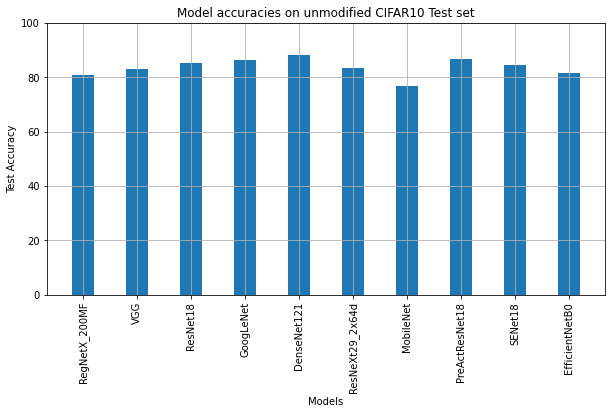

In [9]:
model_names = accuracies.keys()
model_accs = accuracies.values()

fig = plt.figure(figsize = (10, 5)) 
# creating the bar plot 
plt.bar(model_names, model_accs,  
        width = 0.4) 
plt.xticks(range(0,len(model_names)), model_names, rotation='vertical')
plt.ylim(0,100)
plt.grid(True)

plt.xlabel("Models") 
plt.ylabel("Test Accuracy") 
plt.title("Model accuracies on unmodified CIFAR10 Test set") 
plt.show() 


# Adversarial Example Generation

In [10]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

Now, we can define the function that creates the adversarial examples by perturbing the original inputs. The fgsm_attack function takes three inputs, image is the original clean image (x), epsilon is the pixel-wise perturbation amount (ϵ), and data_grad is gradient of the loss w.r.t the input image $(∇_xJ(θ,x,y))$. The function then creates perturbed image as:

perturbed_image = image + epsilon ∗ sign(data_grad) = x + ϵ ∗ sign(∇_xJ(θ,x,y))

Finally, in order to maintain the original range of the data, the perturbed image is clipped to range [0,1].

In [11]:
# Fast Gradient Sign Attack attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Test Function

Each call to this test function performs a full test step on the CIFAR test set and reports a final accuracy. However, this function also takes an epsilon input. This is because the test function reports the accuracy of a model that is under attack from an adversary with strength ϵ. More specifically, for each sample in the test set, the function computes the gradient of the loss w.r.t the input data (data_grad), creates a perturbed image with fgsm_attack (perturbed_data), then checks to see if the perturbed example is adversarial. In addition to testing the accuracy of the model, the function also saves and returns some successful adversarial examples to be visualized later.

In [16]:
def test_fgsm( model, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    loss = None
    criterion = nn.CrossEntropyLoss()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # MNIST Test dataset and dataloader declaration
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)

    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=1, shuffle=True, num_workers=2)
    
    model.eval()
    # Loop over all examples in test set
    for image, target in test_loader:
        # Send the data and label to the device
        image, target = image.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        image.requires_grad = True

        # Forward pass the data through the model
        output = model(image)

        # get the index of the max log-probability
        init_pred = output.max(1, keepdim=True)[1] 
        
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = criterion(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        image_grad = image.grad.data

        # Call FGSM Attack
        perturbed_image = fgsm_attack(image, epsilon, image_grad)

        # Re-classify the perturbed image
        output = model(perturbed_image)

        # Check for success
        # get the index of the max log-probability
        final_pred = output.max(1, keepdim=True)[1] 
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

def test_modified_accuracies():
    epsilons = [0, .05, .1, .15, .2, .25, .3]
    results = {}

    map_location = None if torch.cuda.is_available() else 'cpu'
    epsilon = 0
    
    for e in epsilons:
        accuracies = {}
        examples = {}
        print("Processing for e = {}",e)
        for m in models.keys():
            checkpoint_path = "./checkpoint/" + m + ".torch"
            checkpoint = torch.load(checkpoint_path, map_location=map_location)
            new_state_dict = OrderedDict()

            model = models[m]
            model = model.to(device)
            model = CustomDataParallel(model)

            model.load_state_dict(checkpoint['model_state_dict'], strict=False)

            print("Loaded model {}.".format(m))
            acc, example = test_fgsm(model, e)
            accuracies[m] = acc
            examples[m] = example
            break
        results[e] = {"accuracies": accuracies, "examples": examples}
    return results

In [17]:
import json

results = test_modified_accuracies()
json_str = json.dumps(results)
f = open("results.json","w")
f.write(json_str)
f.close()

Processing for e = {} 0
<class 'torch.nn.parallel.data_parallel.DataParallel'>
Loaded model RegNetX_200MF.
<class 'torch.nn.parallel.data_parallel.DataParallel'>
Loaded model VGG.
<class 'torch.nn.parallel.data_parallel.DataParallel'>
Loaded model ResNet18.
<class 'torch.nn.parallel.data_parallel.DataParallel'>
Loaded model GoogLeNet.
<class 'torch.nn.parallel.data_parallel.DataParallel'>
Loaded model DenseNet121.
<class 'torch.nn.parallel.data_parallel.DataParallel'>
Loaded model ResNeXt29_2x64d.
<class 'torch.nn.parallel.data_parallel.DataParallel'>
Loaded model MobileNet.
<class 'torch.nn.parallel.data_parallel.DataParallel'>
Loaded model PreActResNet18.
<class 'torch.nn.parallel.data_parallel.DataParallel'>
Loaded model SENet18.
<class 'torch.nn.parallel.data_parallel.DataParallel'>
Loaded model EfficientNetB0.
Processing for e = {} 0.05
<class 'torch.nn.parallel.data_parallel.DataParallel'>
Loaded model RegNetX_200MF.
<class 'torch.nn.parallel.data_parallel.DataParallel'>
Loaded m

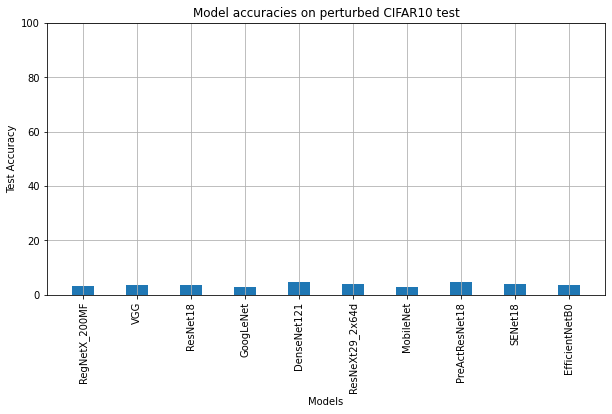

In [38]:
model_names = ['RegNetX_200MF', 'VGG', 'ResNet18', 'GoogLeNet', 'DenseNet121', 'ResNeXt29_2x64d', 'MobileNet', 'PreActResNet18','SENet18', 'EfficientNetB0' ]
model_accs = [0.3167, 0.3465, 0.37, 0.2793, 0.4661, 0.3995, 0.2882, 0.4742, 0.378, 0.3662]

model_accs = [e * 10 for e in model_accs]

fig = plt.figure(figsize = (10, 5)) 
# creating the bar plot 
plt.bar(model_names, model_accs,  
        width = 0.4) 
plt.xticks(range(0,len(model_names)), model_names, rotation='vertical')
plt.ylim(0,100)
plt.grid(True)

plt.xlabel("Models") 
plt.ylabel("Test Accuracy") 
plt.title("Model accuracies on perturbed CIFAR10 test") 
plt.show() 


In [39]:
results

{}